In [1]:
import os
os.chdir('D:\\Gnan\\DA\\KMU\\Prediction-COVID-19')
from utils import *

import scipy.stats as stats
from scipy.stats import shapiro
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import kendalltau
from sklearn.linear_model import LinearRegression
import seaborn as sns

import statsmodels.api as sm
sns.set_theme(style = 'darkgrid')
from colorama import Fore, Back, Style

import warnings
warnings.filterwarnings('ignore')

In [2]:
def g_shapiro(name, x):
    print(f'{name} 검정 통계량 :', shapiro(x)[0], f', {name} p-value :', shapiro(x)[1])
    if shapiro(x)[1] >= 0.05:
        print(f'{name}은 정규성을 만족')
    else:
        print(f'{name}은 정규성을 만족하지 않음')
    
def g_corr_heatmap(df):
    corr_pearson = df.corr(method = 'pearson')
    corr_spearman = df.corr(method = 'spearman')
    corr_kendall = df.corr(method = 'kendall')
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    sns.heatmap(corr_pearson, annot=True, cmap='coolwarm', ax = axes[0])
    axes[0].set_title('Pearson Correlation')
    sns.heatmap(corr_spearman, annot=True, cmap='coolwarm', ax = axes[1])
    axes[1].set_title('Spearman Correlation')
    sns.heatmap(corr_kendall, annot=True, cmap='coolwarm', ax = axes[2])
    axes[2].set_title('Kendall Correlation')
    
    plt.tight_layout()
    plt.show()
    
def g_corr(df, y):
    corr_method_list = ['Pearson', 'Spearman', 'Kendall']
    method_num = 0
    col_list = []
    
    for col in df.columns[2:]:
        x = df[col]
        print(Fore.MAGENTA + col + Fore.BLACK + '와 Difference의 상관 분석')
        print('')
        method_num = 0
        for method in corr_method_list:

            if method_num == 0:
                corr_ = pearsonr
            elif method_num == 1:
                corr_ = spearmanr
            else:
                corr_ = kendalltau


            corr_coef, p_value = corr_(x, y)
            print(Fore.BLACK + f"    {method} correlation coefficient:", corr_coef)
            print(Fore.BLACK + "    p-value:", p_value)
            if p_value < 0.05:
                print(Fore.RED + '    귀무가설 기각, 상관계수는 유의함')
                if col not in col_list:
                    col_list.append(col)
                    
            else:
                print(Fore.BLUE + '    귀무가설 채택, 상관계수는 유의하지 않음')
            print('')

            method_num += 1
            
    return col_list

def g_OLS(df, y, col_list):
    lr = LinearRegression()
    
    for col in col_list:
        x = df[col]
        lr.fit(x.values.reshape(-1, 1), y.values.reshape(-1, 1))
        y2 = lr.coef_[0]*x + lr.intercept_
        sns.scatterplot(x = x, y = y, data = df)
        sns.lineplot(x = x, y = y2, color = 'red')
        plt.show()

        print(f'y = {lr.coef_[0][0]:.4f}x + {lr.intercept_[0]:.4f}')
        print('')
        
        results = sm.OLS(y, sm.add_constant(df[col])).fit()
        print(results.summary())
        
def g_loess(df, y, col_list):
    
    for col in col_list:
        print(col)
        x = df[col]
        lowess = sm.nonparametric.lowess(y, x)

        sns.scatterplot(x = x, y = y, data = df)
        sns.lineplot(x = lowess[:, 0], y = lowess[:, 1], color = 'red')
        plt.show()

        lowess_summary = sm.OLS(lowess[:, 1], sm.add_constant(lowess[:, 0])).fit().summary()
        print(lowess_summary)
        print('')

# Infected

In [82]:
key = 'Infected'
var_list = ['up1', 'up2', 'down1', 'down2']
city_list = ['강원', '경기', '경남', '경북', '광주', '대구', 
          '대전', '부산', '서울', '세종', '울산', '인천',
          '전남', '전북', '제주', '충남', '충북']

path = f'Data/Predicted/Stricgency/{key}/valid_score.pkl'
with open(path, 'rb') as f:
    dic_valid_score = pickle.load(f)
    
df_cities = pd.read_csv('Data/Statistics/Correlation.csv', encoding = 'cp949')
df_movement = pd.read_csv('Data/Statistics/Movement.csv', encoding = 'cp949')
var_date_index = {'Infected' : {'up1' : 5, 'up2' : 56, 'down1' : 24, 'down2' : 73},
                  'SIR' : {'up1' : 6, 'up2' : 57, 'down1' : 25, 'down2' : 74}}

In [83]:
dic_valid = {}
for var in var_list:
    valid_list = []
    for city in city_list:
        valid_list.append([city, dic_valid_score[var][city]['best_model'][3]])
        
    dic_valid[var] = valid_list
    
dic_valid.keys()

dic_df = {}
for var in var_list:
    dic_df[var] = pd.concat([pd.DataFrame(dic_valid[var], columns = ['City', 'Difference']), df_cities.iloc[:, 1:]], axis = 1)
    dic_df[var]['Movement'] = (df_movement.sort_index(axis = 1)
                               .iloc[var_date_index[key][var],:-1]
                               .reset_index(drop = True)
                               .astype('int64'))

Population 검정 통계량 : 0.6380905508995056 , Population p-value : 2.49221902777208e-05
Population은 정규성을 만족하지 않음


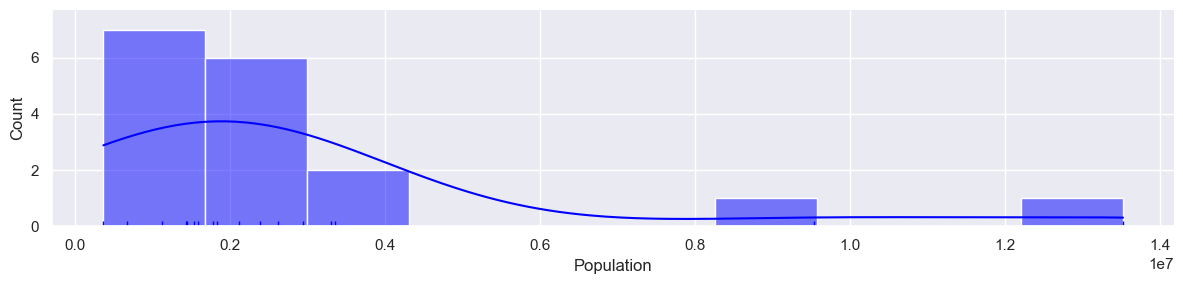

Area 검정 통계량 : 0.8241554498672485 , Area p-value : 0.004435380920767784
Area은 정규성을 만족하지 않음


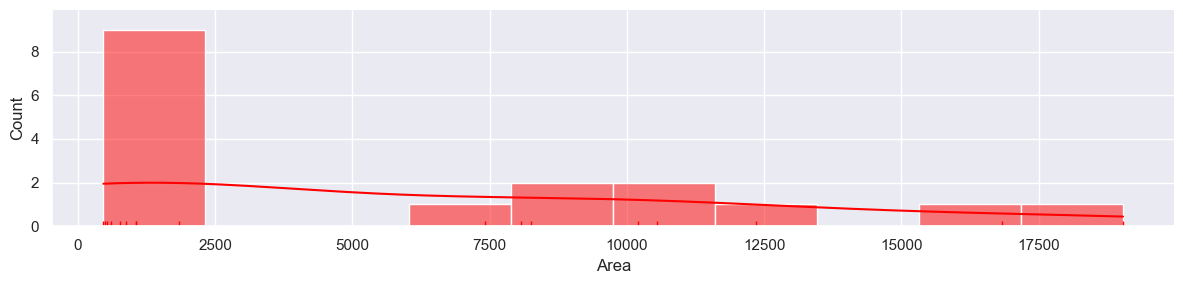

Population density 검정 통계량 : 0.5482955574989319 , Population density p-value : 3.4245413189637475e-06
Population density은 정규성을 만족하지 않음


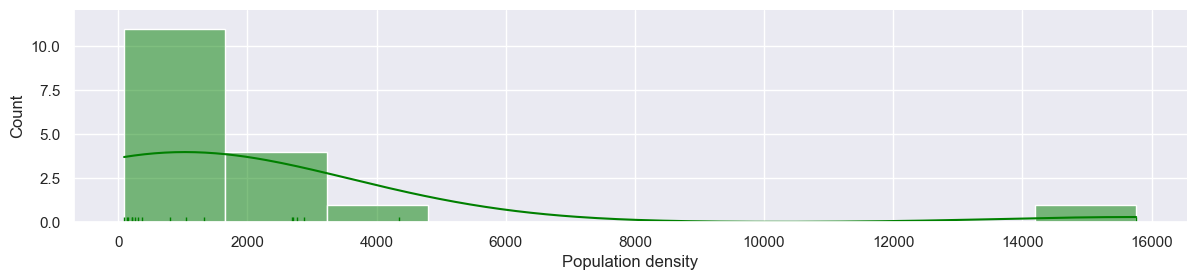

Elderly Ratio 검정 통계량 : 0.9757487773895264 , Elderly Ratio p-value : 0.9088438749313354
Elderly Ratio은 정규성을 만족


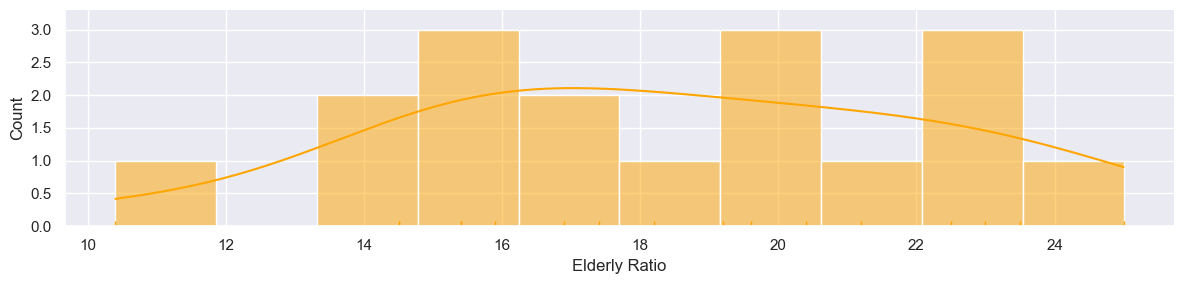

Movement 검정 통계량 : 0.6712006330490112 , Movement p-value : 5.5538956075906754e-05
Movement은 정규성을 만족하지 않음


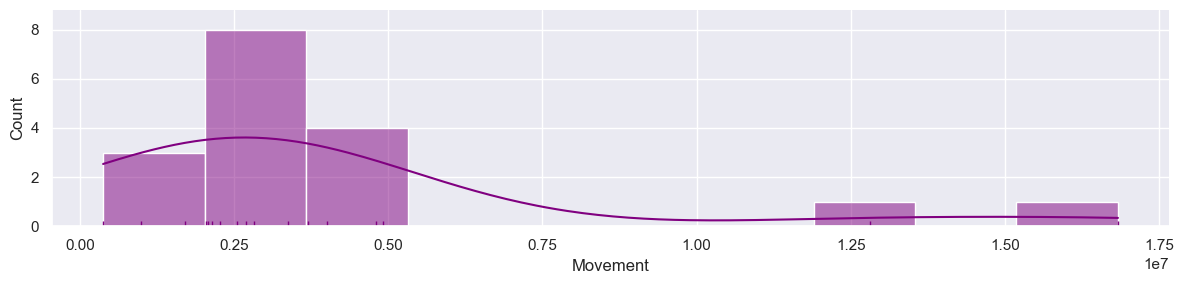

In [84]:
i = 0
df = dic_df['up1']
color_list = ['blue', 'red', 'green', 'orange', 'purple']
for col in df.columns[2:]:
    g_shapiro(col, df[col])
    sns.displot(df[col], color = color_list[i], kde = True, rug = True, aspect = 4, height = 3, bins = 10)
    plt.show()
    i += 1

## up1

In [86]:
df = dic_df['up1']
df.describe()

,Difference,Population,Area,Population density,Elderly Ratio,Movement
count,17.000000,1.700000e+01,17.000000,17.000000,17.000000,1.700000e+01
mean,262.483266,3.037390e+06,5907.764706,2122.923322,18.411765,4.124619e+06
std,581.697951,3.378366e+06,6206.492080,3751.805437,3.900462,4.261384e+06
min,-757.804688,3.704390e+05,465.000000,91.460309,10.400000,3.762110e+05
25%,-1.429871,1.454068e+06,770.000000,221.364594,15.400000,2.084111e+06
50%,178.418945,1.834016e+06,1850.000000,796.643011,18.200000,2.687227e+06
75%,337.678223,2.952839e+06,10197.000000,2702.658371,21.200000,4.006086e+06
max,2228.193359,1.352730e+07,19035.000000,15761.044630,25.000000,1.683307e+07


### 정규성 검정

Difference 검정 통계량 : 0.700035572052002 , Difference p-value : 0.00011570812057470903
Difference은 정규성을 만족하지 않음


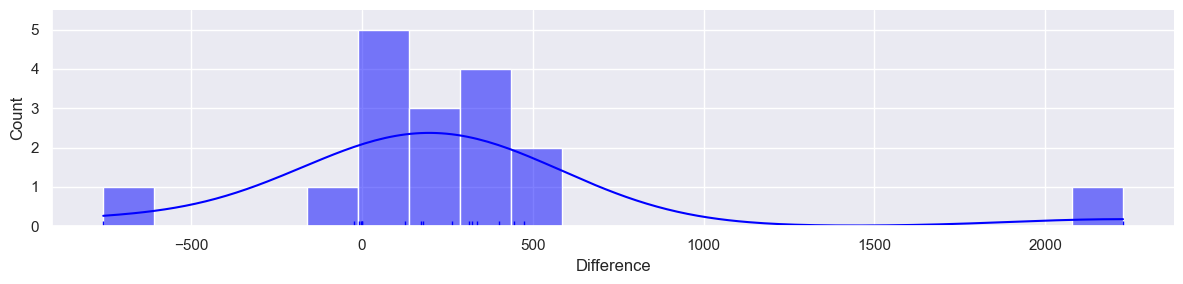

In [7]:
g_shapiro('Difference', df['Difference'])
sns.displot(df['Difference'], color = 'blue', kde = True, rug = True, aspect = 4, height = 3, bins = 20)
plt.show()

## 상관분석

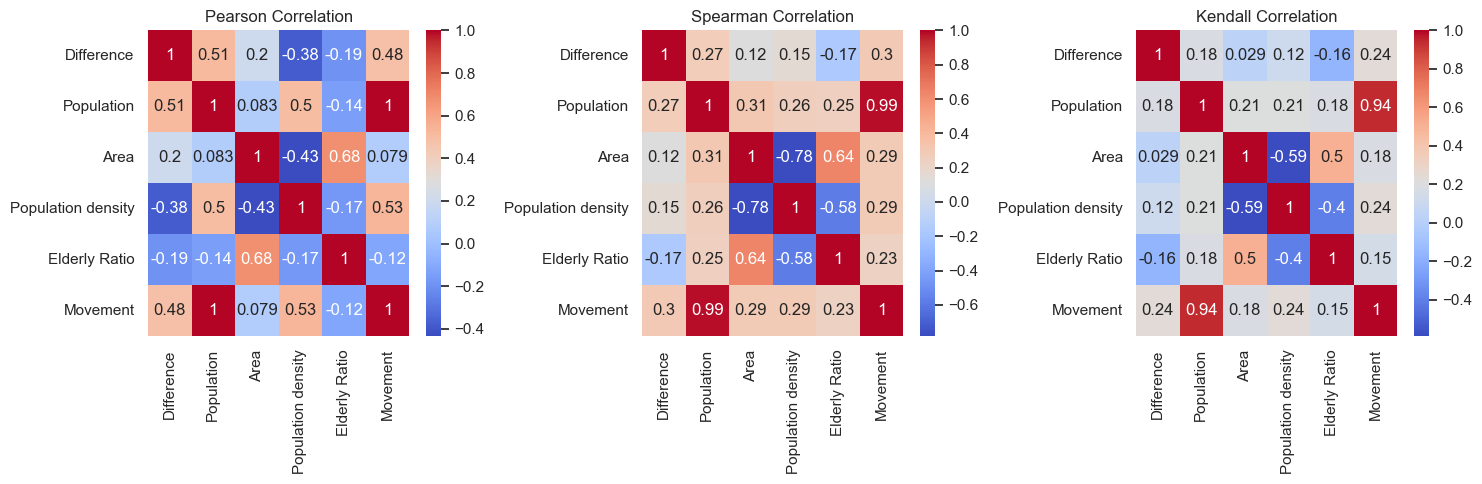

In [8]:
g_corr_heatmap(df)

In [9]:
y = df['Difference']
col_list = g_corr(df, y)

Population와 Difference의 상관 분석

    Pearson correlation coefficient: 0.510060949817545
    p-value: 0.03645783390681061
    귀무가설 기각, 상관계수는 유의함

    Spearman correlation coefficient: 0.26960784313725494
    p-value: 0.2953357994714052
    귀무가설 채택, 상관계수는 유의하지 않음

    Kendall correlation coefficient: 0.1764705882352941
    p-value: 0.34884640290128766
    귀무가설 채택, 상관계수는 유의하지 않음

Area와 Difference의 상관 분석

    Pearson correlation coefficient: 0.20195689142920187
    p-value: 0.4369668669795611
    귀무가설 채택, 상관계수는 유의하지 않음

    Spearman correlation coefficient: 0.11519607843137256
    p-value: 0.659750043107423
    귀무가설 채택, 상관계수는 유의하지 않음

    Kendall correlation coefficient: 0.02941176470588235
    p-value: 0.9031966906069087
    귀무가설 채택, 상관계수는 유의하지 않음

Population density와 Difference의 상관 분석

    Pearson correlation coefficient: -0.382059980843579
    p-value: 0.13018240875728634
    귀무가설 채택, 상관계수는 유의하지 않음

    Spearman correlation coefficient: 0.1519607843137255
    p-value: 0.5604155062809044
 

## 선형회귀분석

### OLS

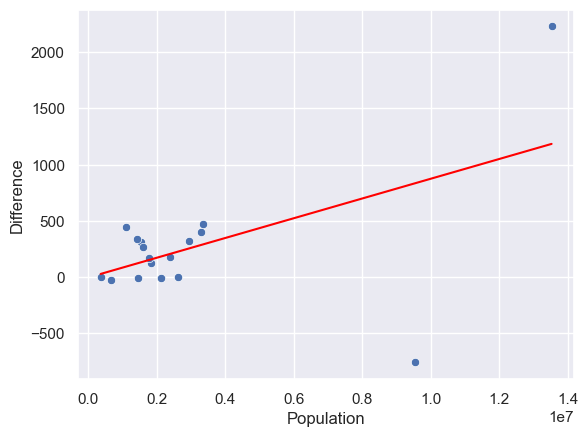

y = 0.0001x + -4.2722

                            OLS Regression Results                            
Dep. Variable:             Difference   R-squared:                       0.260
Model:                            OLS   Adj. R-squared:                  0.211
Method:                 Least Squares   F-statistic:                     5.275
Date:                Thu, 29 Jun 2023   Prob (F-statistic):             0.0365
Time:                        01:48:46   Log-Likelihood:                -129.27
No. Observations:                  17   AIC:                             262.5
Df Residuals:                      15   BIC:                             264.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.2722    170.

In [10]:
y = df['Difference']
g_OLS(df, y, col_list)

### LOESS

Population


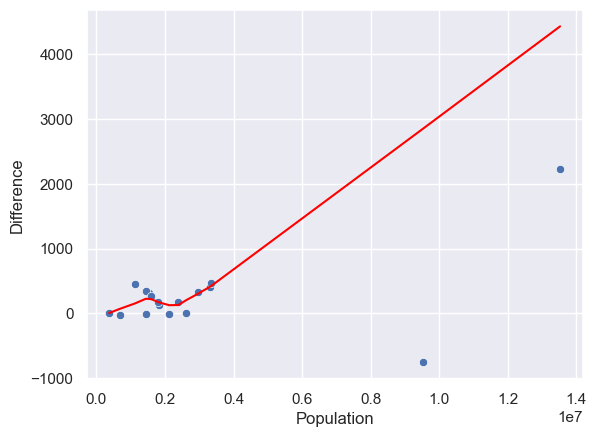

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.964
Method:                 Least Squares   F-statistic:                     429.3
Date:                Thu, 29 Jun 2023   Prob (F-statistic):           1.89e-12
Time:                        01:48:46   Log-Likelihood:                -115.05
No. Observations:                  17   AIC:                             234.1
Df Residuals:                      15   BIC:                             235.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -435.3407     74.042     -5.880      0.0

In [11]:
y = df['Difference']
g_loess(df, y, col_list)

## up2

In [87]:
df = dic_df['up2']
df.describe()

,Difference,Population,Area,Population density,Elderly Ratio,Movement
count,17.000000,1.700000e+01,17.000000,17.000000,17.000000,1.700000e+01
mean,453.041788,3.037390e+06,5907.764706,2122.923322,18.411765,4.249681e+06
std,534.559905,3.378366e+06,6206.492080,3751.805437,3.900462,4.419478e+06
min,-64.246826,3.704390e+05,465.000000,91.460309,10.400000,3.948960e+05
25%,74.229187,1.454068e+06,770.000000,221.364594,15.400000,2.147918e+06
50%,352.714844,1.834016e+06,1850.000000,796.643011,18.200000,2.746642e+06
75%,567.007324,2.952839e+06,10197.000000,2702.658371,21.200000,4.134903e+06
max,2160.109375,1.352730e+07,19035.000000,15761.044630,25.000000,1.740155e+07


### 정규성 검정

Difference 검정 통계량 : 0.7775758504867554 , Difference p-value : 0.0010157424258068204
Difference은 정규성을 만족하지 않음


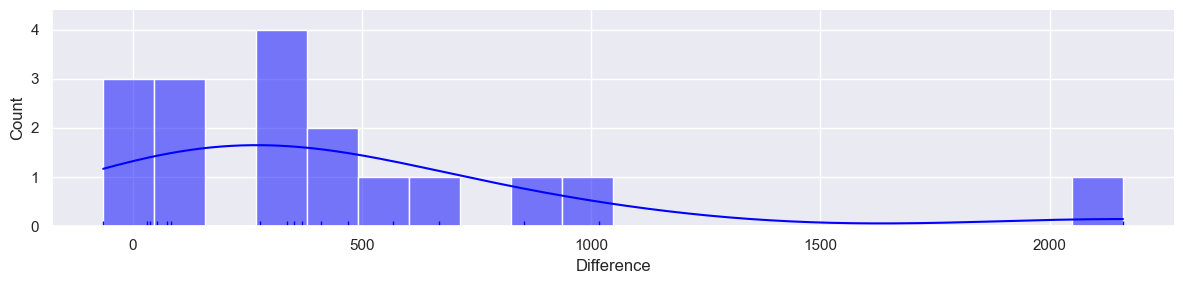

In [13]:
g_shapiro('Difference', df['Difference'])
sns.displot(df['Difference'], color = 'blue', kde = True, rug = True, aspect = 4, height = 3, bins = 20)
plt.show()

## 상관분석

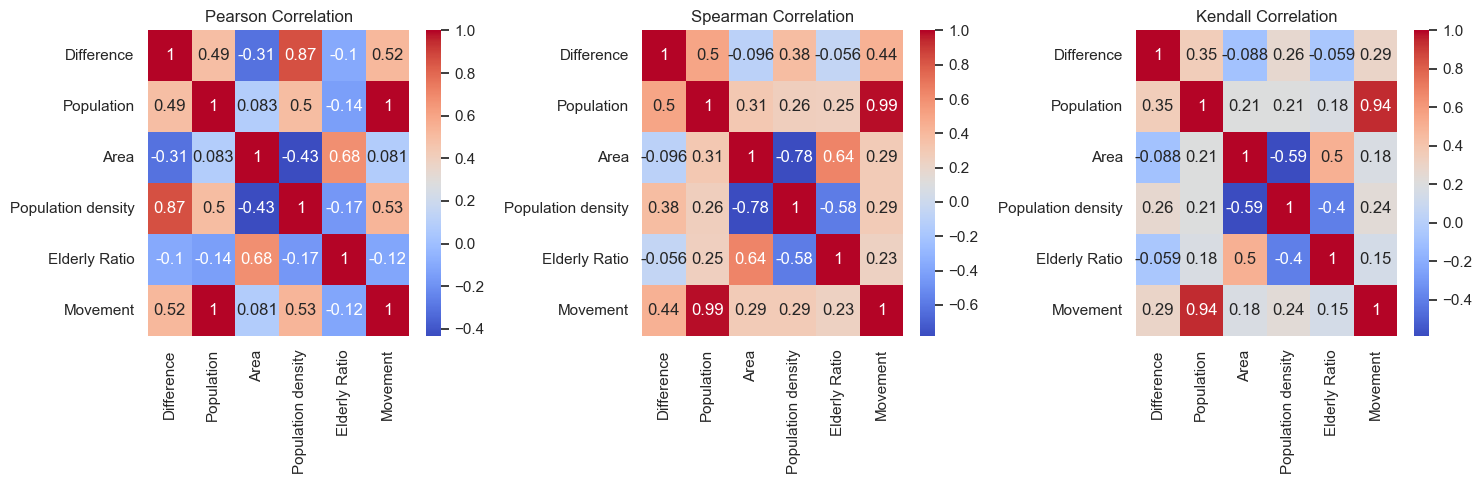

In [14]:
g_corr_heatmap(df)

In [15]:
y = df['Difference']
col_list = g_corr(df, y)

Population와 Difference의 상관 분석

    Pearson correlation coefficient: 0.49063313897082617
    p-value: 0.0455378023237543
    귀무가설 기각, 상관계수는 유의함

    Spearman correlation coefficient: 0.5000000000000001
    p-value: 0.040968955955836106
    귀무가설 기각, 상관계수는 유의함

    Kendall correlation coefficient: 0.3529411764705882
    p-value: 0.05175324945907756
    귀무가설 채택, 상관계수는 유의하지 않음

Area와 Difference의 상관 분석

    Pearson correlation coefficient: -0.3051112828441199
    p-value: 0.23371504073256075
    귀무가설 채택, 상관계수는 유의하지 않음

    Spearman correlation coefficient: -0.09558823529411767
    p-value: 0.7151579154299805
    귀무가설 채택, 상관계수는 유의하지 않음

    Kendall correlation coefficient: -0.08823529411764705
    p-value: 0.6553075802476113
    귀무가설 채택, 상관계수는 유의하지 않음

Population density와 Difference의 상관 분석

    Pearson correlation coefficient: 0.8653719863961216
    p-value: 7.252565360560796e-06
    귀무가설 기각, 상관계수는 유의함

    Spearman correlation coefficient: 0.37500000000000006
    p-value: 0.13803484396804858

### OLS

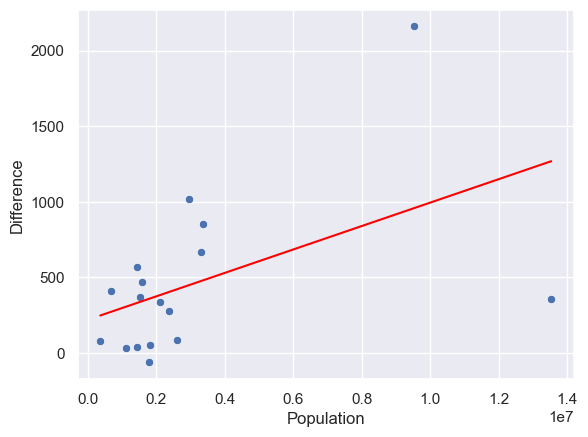

y = 0.0001x + 217.2400

                            OLS Regression Results                            
Dep. Variable:             Difference   R-squared:                       0.241
Model:                            OLS   Adj. R-squared:                  0.190
Method:                 Least Squares   F-statistic:                     4.756
Date:                Thu, 29 Jun 2023   Prob (F-statistic):             0.0455
Time:                        01:48:48   Log-Likelihood:                -128.05
No. Observations:                  17   AIC:                             260.1
Df Residuals:                      15   BIC:                             261.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        217.2400    159

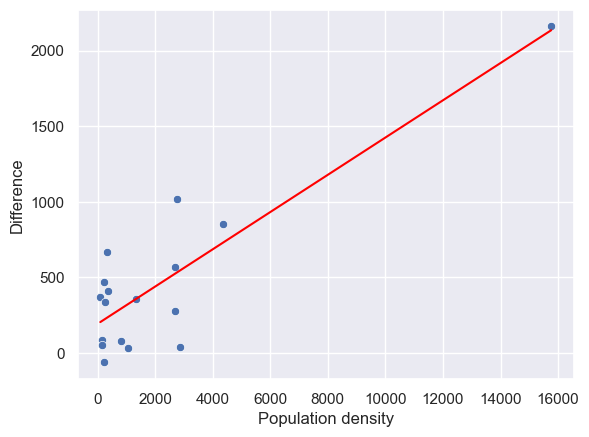

y = 0.1233x + 191.2879

                            OLS Regression Results                            
Dep. Variable:             Difference   R-squared:                       0.749
Model:                            OLS   Adj. R-squared:                  0.732
Method:                 Least Squares   F-statistic:                     44.73
Date:                Thu, 29 Jun 2023   Prob (F-statistic):           7.25e-06
Time:                        01:48:48   Log-Likelihood:                -118.65
No. Observations:                  17   AIC:                             241.3
Df Residuals:                      15   BIC:                             243.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const       

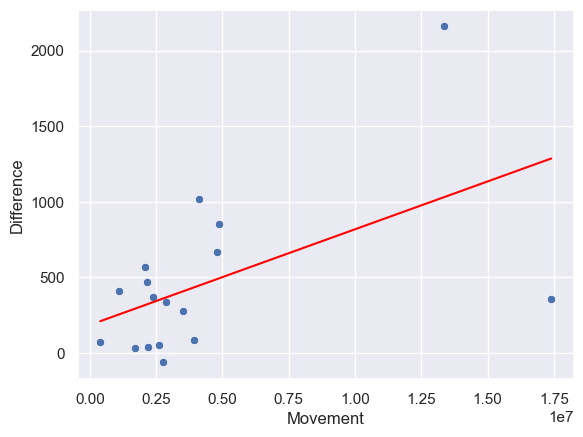

y = 0.0001x + 183.9100

                            OLS Regression Results                            
Dep. Variable:             Difference   R-squared:                       0.274
Model:                            OLS   Adj. R-squared:                  0.226
Method:                 Least Squares   F-statistic:                     5.665
Date:                Thu, 29 Jun 2023   Prob (F-statistic):             0.0310
Time:                        01:48:48   Log-Likelihood:                -127.67
No. Observations:                  17   AIC:                             259.3
Df Residuals:                      15   BIC:                             261.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        183.9100    160

In [16]:
y = df['Difference']
g_OLS(df, y, col_list)

### LOESS

Population


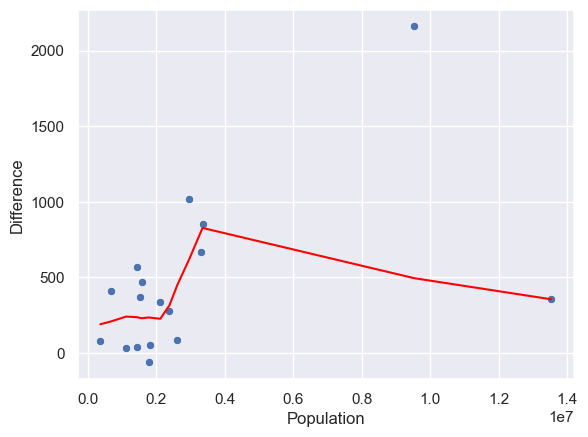

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     1.427
Date:                Thu, 29 Jun 2023   Prob (F-statistic):              0.251
Time:                        01:48:49   Log-Likelihood:                -113.54
No. Observations:                  17   AIC:                             231.1
Df Residuals:                      15   BIC:                             232.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        303.8975     67.764      4.485      0.0

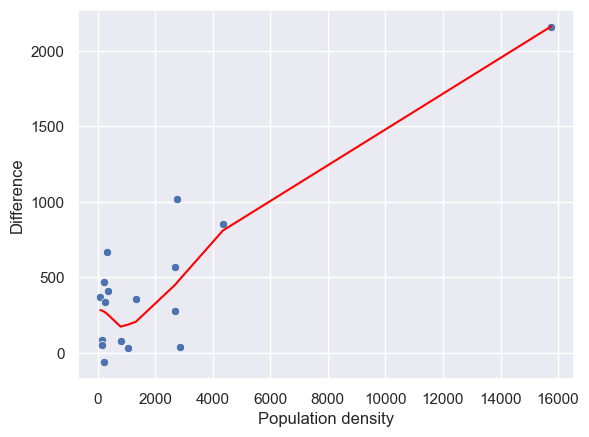

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                     495.0
Date:                Thu, 29 Jun 2023   Prob (F-statistic):           6.70e-13
Time:                        01:48:49   Log-Likelihood:                -98.221
No. Observations:                  17   AIC:                             200.4
Df Residuals:                      15   BIC:                             202.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        182.9108     23.363      7.829      0.0

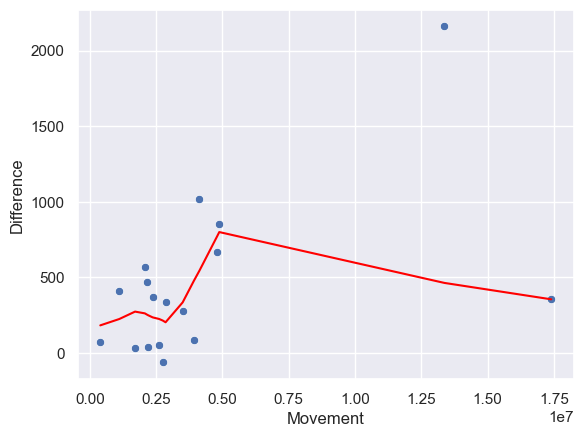

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.096
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     1.602
Date:                Thu, 29 Jun 2023   Prob (F-statistic):              0.225
Time:                        01:48:49   Log-Likelihood:                -112.16
No. Observations:                  17   AIC:                             228.3
Df Residuals:                      15   BIC:                             230.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        298.4044     64.507      4.626      0.0

In [17]:
y = df['Difference']
g_loess(df, y, col_list)

## down1

In [88]:
df = dic_df['down1']
df.describe()

,Difference,Population,Area,Population density,Elderly Ratio,Movement
count,17.000000,1.700000e+01,17.000000,17.000000,17.000000,1.700000e+01
mean,138.823843,3.037390e+06,5907.764706,2122.923322,18.411765,4.376731e+06
std,456.673034,3.378366e+06,6206.492080,3751.805437,3.900462,4.528182e+06
min,-132.149170,3.704390e+05,465.000000,91.460309,10.400000,4.099970e+05
25%,-31.403748,1.454068e+06,770.000000,221.364594,15.400000,2.239275e+06
50%,-6.598022,1.834016e+06,1850.000000,796.643011,18.200000,2.899621e+06
75%,85.801270,2.952839e+06,10197.000000,2702.658371,21.200000,4.227334e+06
max,1814.314453,1.352730e+07,19035.000000,15761.044630,25.000000,1.780144e+07


### 정규성 검정

Difference 검정 통계량 : 0.4970725178718567 , Difference p-value : 1.2232851531734923e-06
Difference은 정규성을 만족하지 않음


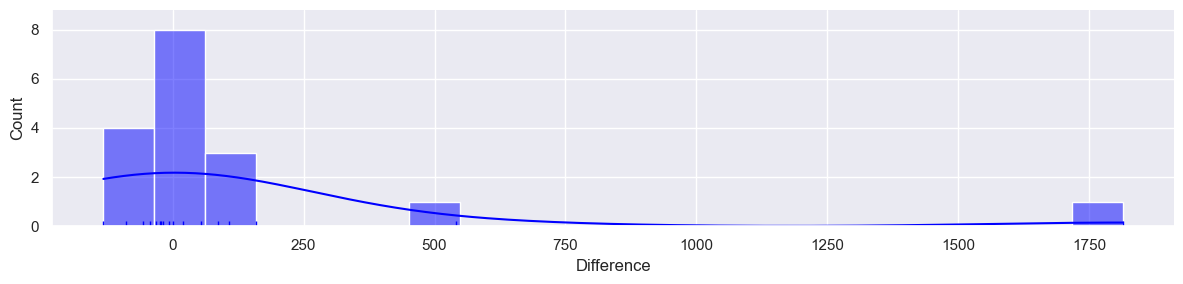

In [19]:
g_shapiro('Difference', df['Difference'])
sns.displot(df['Difference'], color = 'blue', kde = True, rug = True, aspect = 4, height = 3, bins = 20)
plt.show()

## 상관분석

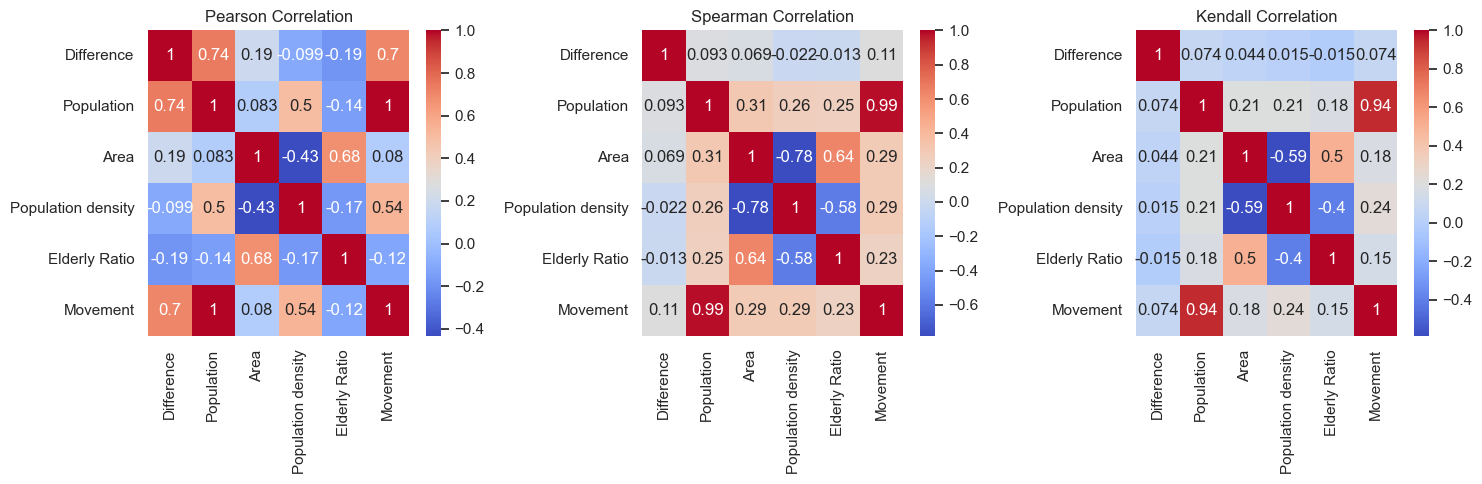

In [20]:
g_corr_heatmap(df)

In [21]:
y = df['Difference']
col_list = g_corr(df, y)

Population와 Difference의 상관 분석

    Pearson correlation coefficient: 0.7406522580406598
    p-value: 0.0006719973426394006
    귀무가설 기각, 상관계수는 유의함

    Spearman correlation coefficient: 0.09313725490196079
    p-value: 0.7221860910253712
    귀무가설 채택, 상관계수는 유의하지 않음

    Kendall correlation coefficient: 0.07352941176470587
    p-value: 0.7150317752938318
    귀무가설 채택, 상관계수는 유의하지 않음

Area와 Difference의 상관 분석

    Pearson correlation coefficient: 0.1903362594092622
    p-value: 0.46433292695725625
    귀무가설 채택, 상관계수는 유의하지 않음

    Spearman correlation coefficient: 0.06862745098039216
    p-value: 0.7935424429160597
    귀무가설 채택, 상관계수는 유의하지 않음

    Kendall correlation coefficient: 0.044117647058823525
    p-value: 0.8393415533036079
    귀무가설 채택, 상관계수는 유의하지 않음

Population density와 Difference의 상관 분석

    Pearson correlation coefficient: -0.09897996686876052
    p-value: 0.7054678218760134
    귀무가설 채택, 상관계수는 유의하지 않음

    Spearman correlation coefficient: -0.022058823529411766
    p-value: 0.933030449

## 선형회귀분석

### OLS

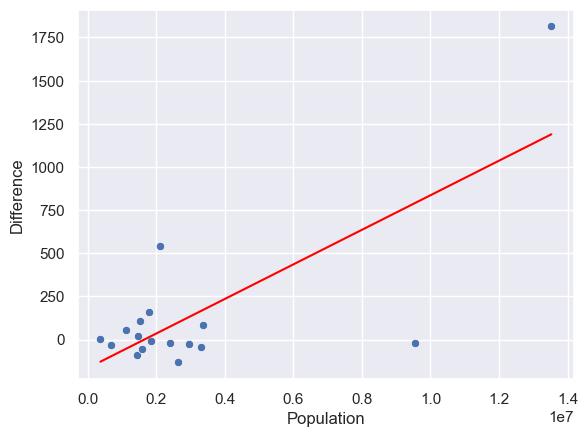

y = 0.0001x + -165.2741

                            OLS Regression Results                            
Dep. Variable:             Difference   R-squared:                       0.549
Model:                            OLS   Adj. R-squared:                  0.518
Method:                 Least Squares   F-statistic:                     18.23
Date:                Thu, 29 Jun 2023   Prob (F-statistic):           0.000672
Time:                        01:48:51   Log-Likelihood:                -120.95
No. Observations:                  17   AIC:                             245.9
Df Residuals:                      15   BIC:                             247.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -165.2741    10

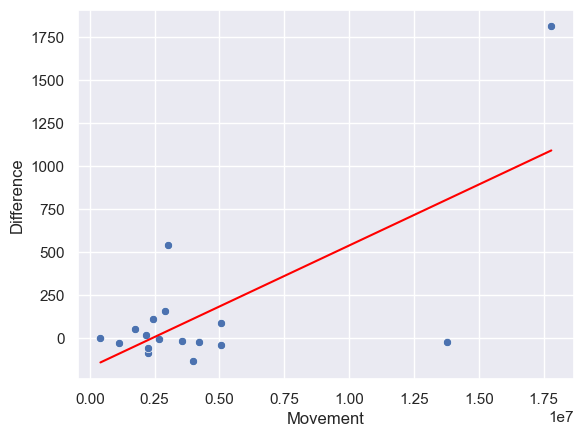

y = 0.0001x + -171.9812

                            OLS Regression Results                            
Dep. Variable:             Difference   R-squared:                       0.496
Model:                            OLS   Adj. R-squared:                  0.462
Method:                 Least Squares   F-statistic:                     14.75
Date:                Thu, 29 Jun 2023   Prob (F-statistic):            0.00160
Time:                        01:48:51   Log-Likelihood:                -121.89
No. Observations:                  17   AIC:                             247.8
Df Residuals:                      15   BIC:                             249.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -171.9812    11

In [22]:
y = df['Difference']
g_OLS(df, y, col_list)

### LOESS

Population


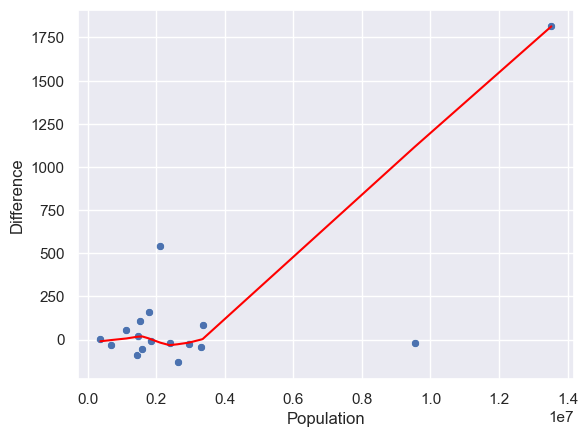

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                     207.6
Date:                Thu, 29 Jun 2023   Prob (F-statistic):           3.42e-10
Time:                        01:48:51   Log-Likelihood:                -106.42
No. Observations:                  17   AIC:                             216.8
Df Residuals:                      15   BIC:                             218.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -265.4101     44.556     -5.957      0.0

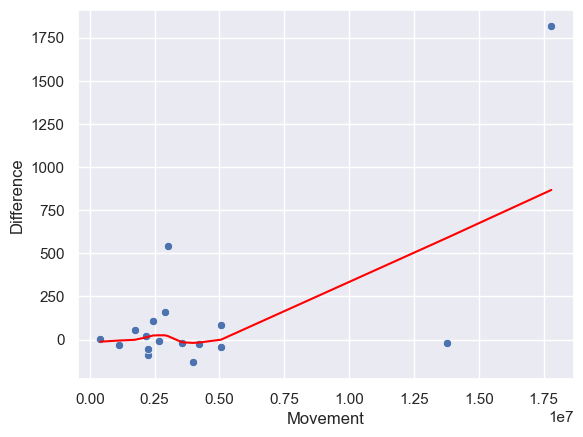

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.913
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                     157.4
Date:                Thu, 29 Jun 2023   Prob (F-statistic):           2.35e-09
Time:                        01:48:51   Log-Likelihood:                -96.418
No. Observations:                  17   AIC:                             196.8
Df Residuals:                      15   BIC:                             198.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -136.9832     25.621     -5.347      0.0

In [23]:
y = df['Difference']
g_loess(df, y, col_list)

## down2

In [89]:
df = dic_df['down2']
df.describe()

,Difference,Population,Area,Population density,Elderly Ratio,Movement
count,17.000000,1.700000e+01,17.000000,17.000000,17.000000,1.700000e+01
mean,41574.761489,3.037390e+06,5907.764706,2122.923322,18.411765,4.494708e+06
std,26460.134225,3.378366e+06,6206.492080,3751.805437,3.900462,4.634275e+06
min,3784.437500,3.704390e+05,465.000000,91.460309,10.400000,4.201950e+05
25%,23860.625000,1.454068e+06,770.000000,221.364594,15.400000,2.303773e+06
50%,32750.218750,1.834016e+06,1850.000000,796.643011,18.200000,3.006089e+06
75%,60775.125000,2.952839e+06,10197.000000,2702.658371,21.200000,4.334967e+06
max,89462.000000,1.352730e+07,19035.000000,15761.044630,25.000000,1.824942e+07


### 정규성 검정

Difference 검정 통계량 : 0.9380044937133789 , Difference p-value : 0.2952806353569031
Difference은 정규성을 만족


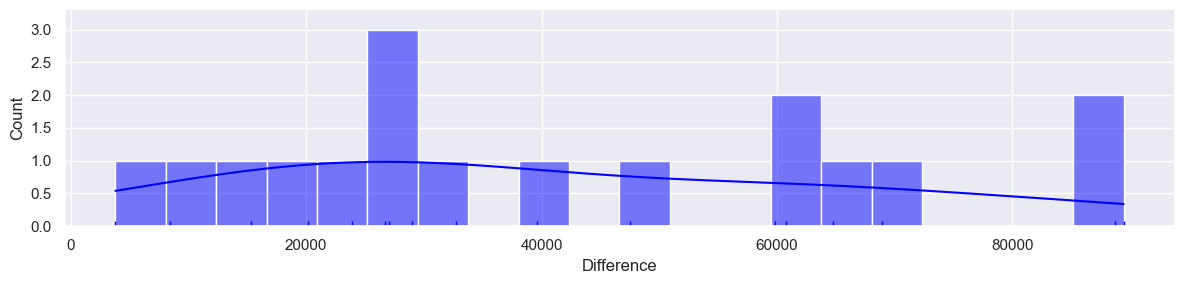

In [25]:
g_shapiro('Difference', df['Difference'])
sns.displot(df['Difference'], color = 'blue', kde = True, rug = True, aspect = 4, height = 3, bins = 20)
plt.show()

## 상관분석

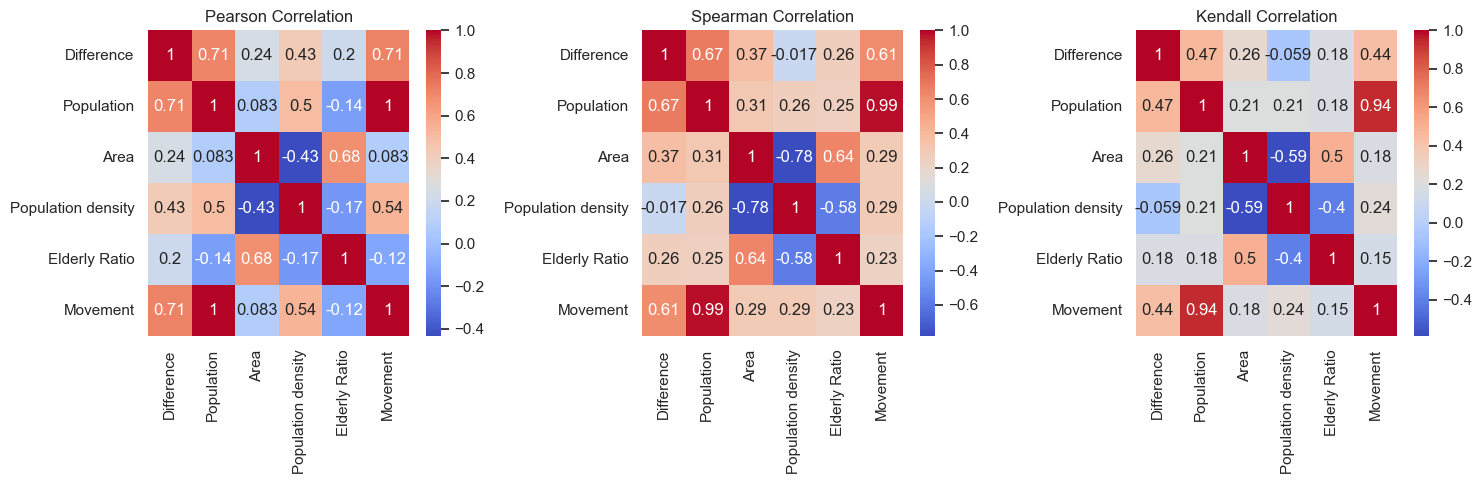

In [26]:
g_corr_heatmap(df)

In [27]:
y = df['Difference']
col_list = g_corr(df, y)

Population와 Difference의 상관 분석

    Pearson correlation coefficient: 0.7097935411213847
    p-value: 0.0014137569965293815
    귀무가설 기각, 상관계수는 유의함

    Spearman correlation coefficient: 0.6740196078431374
    p-value: 0.0030075378038459965
    귀무가설 기각, 상관계수는 유의함

    Kendall correlation coefficient: 0.4705882352941176
    p-value: 0.007921135981245789
    귀무가설 기각, 상관계수는 유의함

Area와 Difference의 상관 분석

    Pearson correlation coefficient: 0.24478142634218722
    p-value: 0.3436902678507748
    귀무가설 채택, 상관계수는 유의하지 않음

    Spearman correlation coefficient: 0.37254901960784315
    p-value: 0.14083572189262192
    귀무가설 채택, 상관계수는 유의하지 않음

    Kendall correlation coefficient: 0.2647058823529411
    p-value: 0.15133363966308636
    귀무가설 채택, 상관계수는 유의하지 않음

Population density와 Difference의 상관 분석

    Pearson correlation coefficient: 0.42664395940064165
    p-value: 0.08766175229052299
    귀무가설 채택, 상관계수는 유의하지 않음

    Spearman correlation coefficient: -0.01715686274509804
    p-value: 0.947890881823222

## 선형회귀분석

### OLS

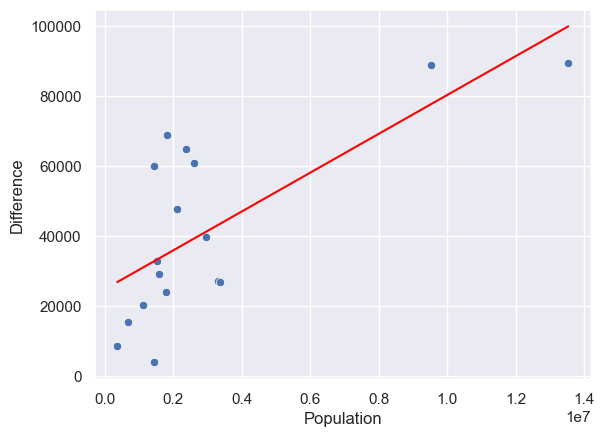

y = 0.0056x + 24689.1089

                            OLS Regression Results                            
Dep. Variable:             Difference   R-squared:                       0.504
Model:                            OLS   Adj. R-squared:                  0.471
Method:                 Least Squares   F-statistic:                     15.23
Date:                Thu, 29 Jun 2023   Prob (F-statistic):            0.00141
Time:                        01:48:53   Log-Likelihood:                -190.77
No. Observations:                  17   AIC:                             385.5
Df Residuals:                      15   BIC:                             387.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.469e+04   63

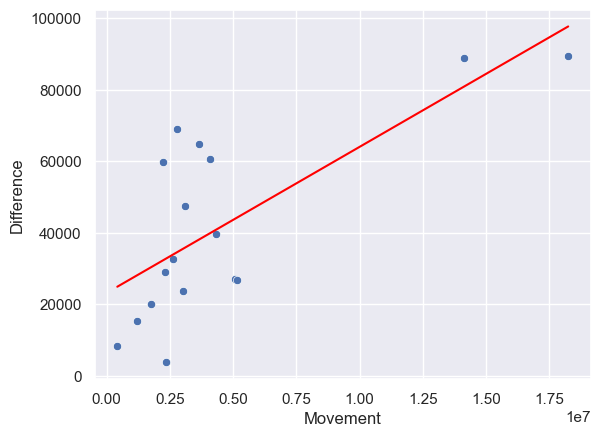

y = 0.0041x + 23235.8155

                            OLS Regression Results                            
Dep. Variable:             Difference   R-squared:                       0.511
Model:                            OLS   Adj. R-squared:                  0.478
Method:                 Least Squares   F-statistic:                     15.65
Date:                Thu, 29 Jun 2023   Prob (F-statistic):            0.00127
Time:                        01:48:53   Log-Likelihood:                -190.65
No. Observations:                  17   AIC:                             385.3
Df Residuals:                      15   BIC:                             387.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.324e+04   65

In [28]:
y = df['Difference']
g_OLS(df, y, col_list)

### LOESS

Population


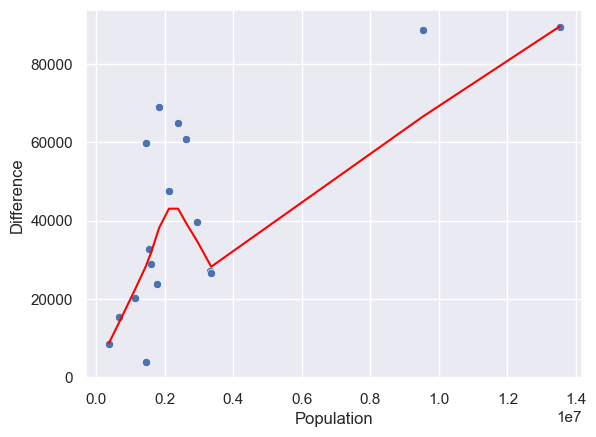

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     81.15
Date:                Thu, 29 Jun 2023   Prob (F-statistic):           1.94e-07
Time:                        01:48:54   Log-Likelihood:                -175.06
No. Observations:                  17   AIC:                             354.1
Df Residuals:                      15   BIC:                             355.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.053e+04   2526.237      8.127      0.0

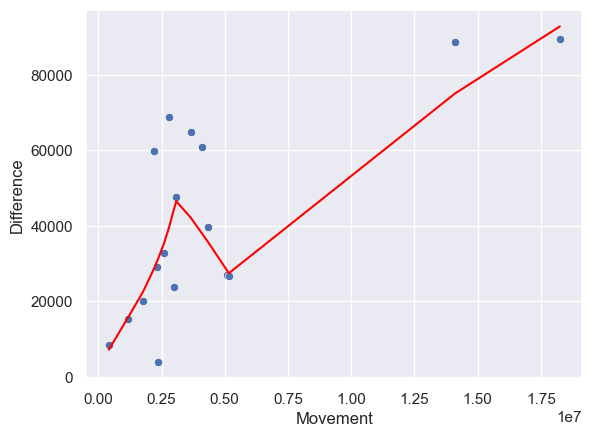

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.826
Model:                            OLS   Adj. R-squared:                  0.814
Method:                 Least Squares   F-statistic:                     71.03
Date:                Thu, 29 Jun 2023   Prob (F-statistic):           4.50e-07
Time:                        01:48:54   Log-Likelihood:                -177.40
No. Observations:                  17   AIC:                             358.8
Df Residuals:                      15   BIC:                             360.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.983e+04   3006.599      6.596      0.0

In [29]:
y = df['Difference']
g_loess(df, y, col_list)

# SIR

In [30]:
key = 'SIR'
var_list = ['up1', 'up2', 'down1', 'down2']
city_list = ['강원', '경기', '경남', '경북', '광주', '대구', 
          '대전', '부산', '서울', '세종', '울산', '인천',
          '전남', '전북', '제주', '충남', '충북']

path = f'Data/Predicted/Stricgency/{key}/valid_score.pkl'
with open(path, 'rb') as f:
    dic_valid_score = pickle.load(f)
    
df_cities = pd.read_csv('Data/Statistics/Correlation.csv', encoding = 'cp949')

In [31]:
dic_valid = {}
for var in var_list:
    valid_list = []
    for city in city_list:
        valid_list.append([city, dic_valid_score[var][city]['best_model'][3]])
        
    dic_valid[var] = valid_list
    
dic_valid.keys()

dic_df = {}
for var in var_list:
    dic_df[var] = pd.concat([pd.DataFrame(dic_valid[var], columns = ['City', 'Difference']), df_cities.iloc[:, 1:]], axis = 1)
    dic_df[var]['Movement'] = (df_movement.sort_index(axis = 1)
                               .iloc[var_date_index[key][var],:-1]
                               .reset_index(drop = True)
                               .astype('int64'))

## up1

In [32]:
df = dic_df['up1']
df.head()

,City,Difference,Population,Area,Population density,Elderly Ratio,Movement
0,강원,-107.864609,1539277,16830,91.460309,22.5,2269308
1,경기,1035.866607,13527299,10197,1326.595960,14.5,16953318
2,경남,-94.102392,3311631,10542,314.136881,19.2,4866917
3,경북,337.473925,2622174,19035,137.755398,23.5,3756940
4,광주,301.893149,1440908,501,2876.063872,15.4,2169744


### 정규성 검정

Difference 검정 통계량 : 0.5732835531234741 , Difference p-value : 5.803489329991862e-06
Difference은 정규성을 만족하지 않음


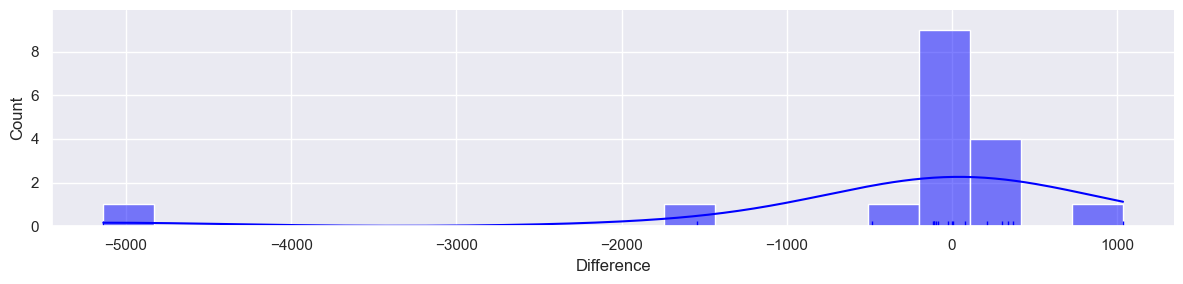

In [33]:
g_shapiro('Difference', df['Difference'])
sns.displot(df['Difference'], color = 'blue', kde = True, rug = True, aspect = 4, height = 3, bins = 20)
plt.show()

## 상관분석

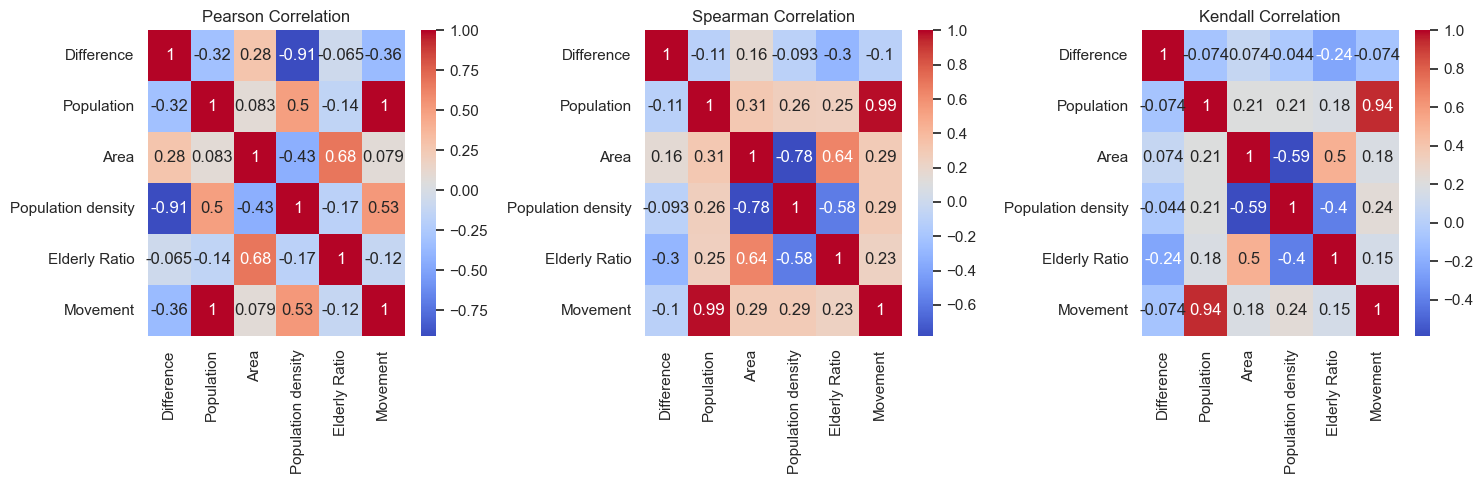

In [34]:
g_corr_heatmap(df)

In [35]:
y = df['Difference']
col_list = g_corr(df, y)

Population와 Difference의 상관 분석

    Pearson correlation coefficient: -0.32011153216918375
    p-value: 0.21035020661177492
    귀무가설 채택, 상관계수는 유의하지 않음

    Spearman correlation coefficient: -0.11274509803921569
    p-value: 0.666592049963725
    귀무가설 채택, 상관계수는 유의하지 않음

    Kendall correlation coefficient: -0.07352941176470587
    p-value: 0.7150317752938318
    귀무가설 채택, 상관계수는 유의하지 않음

Area와 Difference의 상관 분석

    Pearson correlation coefficient: 0.282590538207321
    p-value: 0.27177031358754067
    귀무가설 채택, 상관계수는 유의하지 않음

    Spearman correlation coefficient: 0.15686274509803924
    p-value: 0.5476805847029372
    귀무가설 채택, 상관계수는 유의하지 않음

    Kendall correlation coefficient: 0.07352941176470587
    p-value: 0.7150317752938318
    귀무가설 채택, 상관계수는 유의하지 않음

Population density와 Difference의 상관 분석

    Pearson correlation coefficient: -0.91011731660626
    p-value: 4.0079681127650873e-07
    귀무가설 기각, 상관계수는 유의함

    Spearman correlation coefficient: -0.09313725490196079
    p-value: 0.7221860910

## 선형회귀분석

### OLS

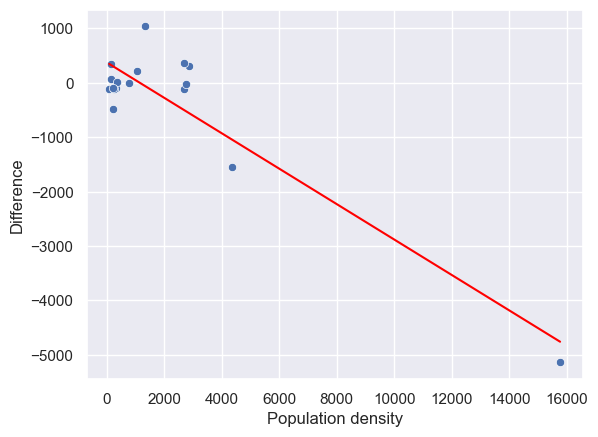

y = -0.3257x + 376.2755

                            OLS Regression Results                            
Dep. Variable:             Difference   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.817
Method:                 Least Squares   F-statistic:                     72.37
Date:                Thu, 29 Jun 2023   Prob (F-statistic):           4.01e-07
Time:                        01:48:56   Log-Likelihood:                -131.07
No. Observations:                  17   AIC:                             266.1
Df Residuals:                      15   BIC:                             267.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const      

In [36]:
y = df['Difference']
g_OLS(df, y, col_list)

### LOESS

Population density


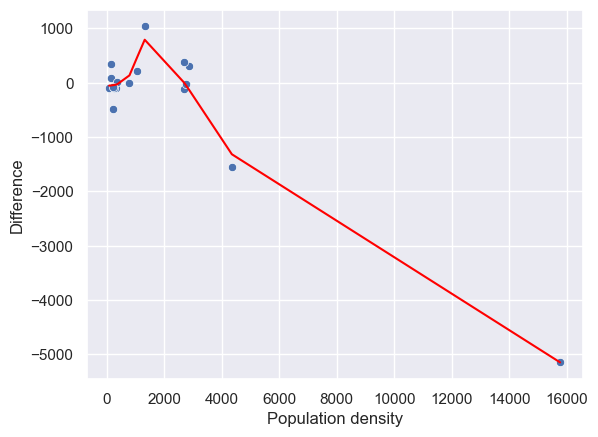

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.882
Method:                 Least Squares   F-statistic:                     120.6
Date:                Thu, 29 Jun 2023   Prob (F-statistic):           1.44e-08
Time:                        01:48:56   Log-Likelihood:                -126.86
No. Observations:                  17   AIC:                             257.7
Df Residuals:                      15   BIC:                             259.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        364.1652    125.937      2.892      0.0

In [37]:
y = df['Difference']
g_loess(df, y, col_list)

## up2

In [38]:
df = dic_df['up2']
df.head()

,City,Difference,Population,Area,Population density,Elderly Ratio,Movement
0,강원,71.645677,1539277,16830,91.460309,22.5,2407919
1,경기,171.121121,13527299,10197,1326.595960,14.5,17765571
2,경남,446.633311,3311631,10542,314.136881,19.2,4925279
3,경북,295.517274,2622174,19035,137.755398,23.5,4017947
4,광주,-99.596095,1440908,501,2876.063872,15.4,2277573


### 정규성 검정

Difference 검정 통계량 : 0.8969458937644958 , Difference p-value : 0.060399193316698074
Difference은 정규성을 만족


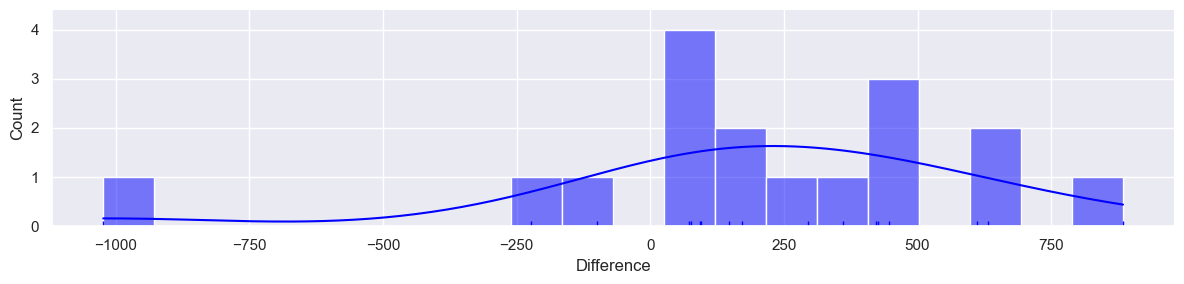

In [39]:
g_shapiro('Difference', df['Difference'])
sns.displot(df['Difference'], color = 'blue', kde = True, rug = True, aspect = 4, height = 3, bins = 20)
plt.show()

## 상관분석

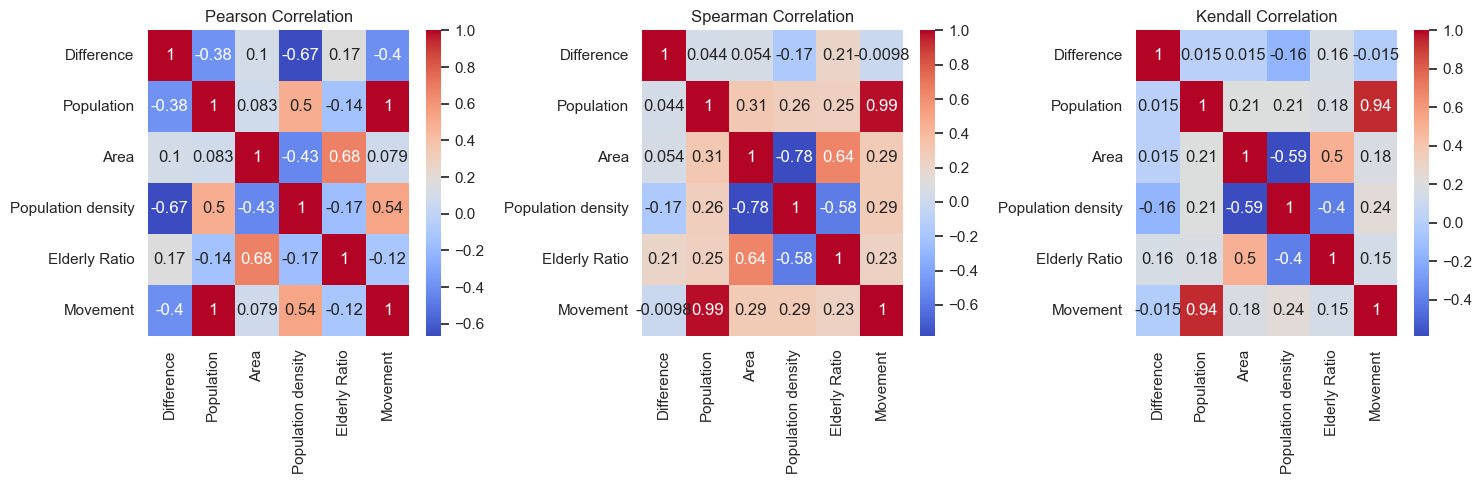

In [40]:
g_corr_heatmap(df)

In [41]:
y = df['Difference']
col_list = g_corr(df, y)

Population와 Difference의 상관 분석

    Pearson correlation coefficient: -0.383292109874256
    p-value: 0.1288444967859096
    귀무가설 채택, 상관계수는 유의하지 않음

    Spearman correlation coefficient: 0.04411764705882353
    p-value: 0.8664832749198724
    귀무가설 채택, 상관계수는 유의하지 않음

    Kendall correlation coefficient: 0.014705882352941175
    p-value: 0.9676638168395322
    귀무가설 채택, 상관계수는 유의하지 않음

Area와 Difference의 상관 분석

    Pearson correlation coefficient: 0.10401619398377715
    p-value: 0.6911584473068039
    귀무가설 채택, 상관계수는 유의하지 않음

    Spearman correlation coefficient: 0.05392156862745098
    p-value: 0.8371514461082935
    귀무가설 채택, 상관계수는 유의하지 않음

    Kendall correlation coefficient: 0.014705882352941175
    p-value: 0.9676638168395322
    귀무가설 채택, 상관계수는 유의하지 않음

Population density와 Difference의 상관 분석

    Pearson correlation coefficient: -0.6676074919220962
    p-value: 0.0034077583745435245
    귀무가설 기각, 상관계수는 유의함

    Spearman correlation coefficient: -0.16666666666666669
    p-value: 0.5226031535

### OLS

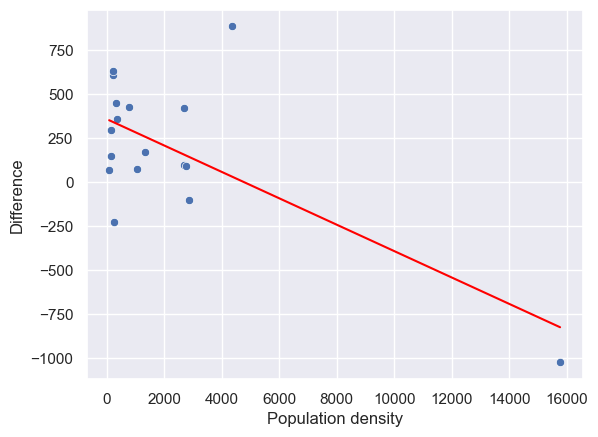

y = -0.0750x + 358.3951

                            OLS Regression Results                            
Dep. Variable:             Difference   R-squared:                       0.446
Model:                            OLS   Adj. R-squared:                  0.409
Method:                 Least Squares   F-statistic:                     12.06
Date:                Thu, 29 Jun 2023   Prob (F-statistic):            0.00341
Time:                        01:48:58   Log-Likelihood:                -121.34
No. Observations:                  17   AIC:                             246.7
Df Residuals:                      15   BIC:                             248.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const      

In [42]:
y = df['Difference']
g_OLS(df, y, col_list)

### LOESS

Population density


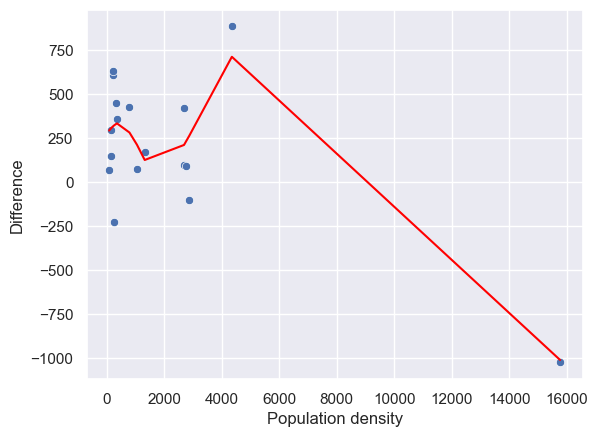

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.702
Model:                            OLS   Adj. R-squared:                  0.683
Method:                 Least Squares   F-statistic:                     35.40
Date:                Thu, 29 Jun 2023   Prob (F-statistic):           2.66e-05
Time:                        01:48:58   Log-Likelihood:                -112.36
No. Observations:                  17   AIC:                             228.7
Df Residuals:                      15   BIC:                             230.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        381.9282     53.670      7.116      0.0

In [43]:
y = df['Difference']
g_loess(df, y, col_list)

## down1

In [44]:
df = dic_df['down1']
df.head()

,City,Difference,Population,Area,Population density,Elderly Ratio,Movement
0,강원,119.685231,1539277,16830,91.460309,22.5,2431510
1,경기,-200.545609,13527299,10197,1326.595960,14.5,17823822
2,경남,-56.735255,3311631,10542,314.136881,19.2,5071967
3,경북,-165.946412,2622174,19035,137.755398,23.5,4010493
4,광주,63.010498,1440908,501,2876.063872,15.4,2266118


### 정규성 검정

Difference 검정 통계량 : 0.6734594106674194 , Difference p-value : 5.875149508938193e-05
Difference은 정규성을 만족하지 않음


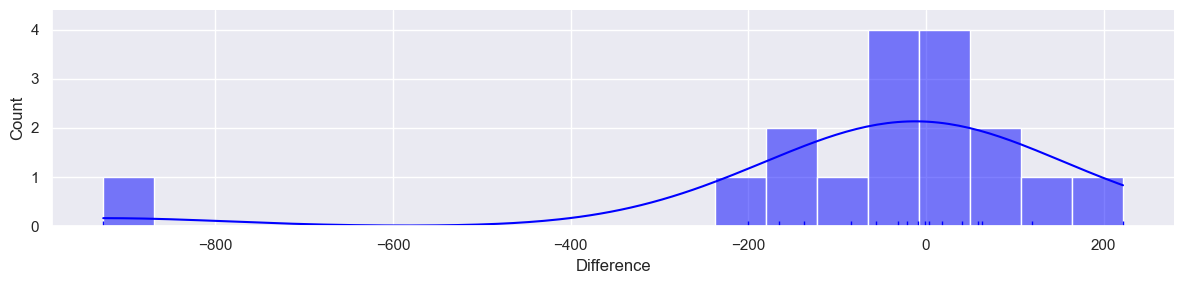

In [45]:
g_shapiro('Difference', df['Difference'])
sns.displot(df['Difference'], color = 'blue', kde = True, rug = True, aspect = 4, height = 3, bins = 20)
plt.show()

## 상관분석

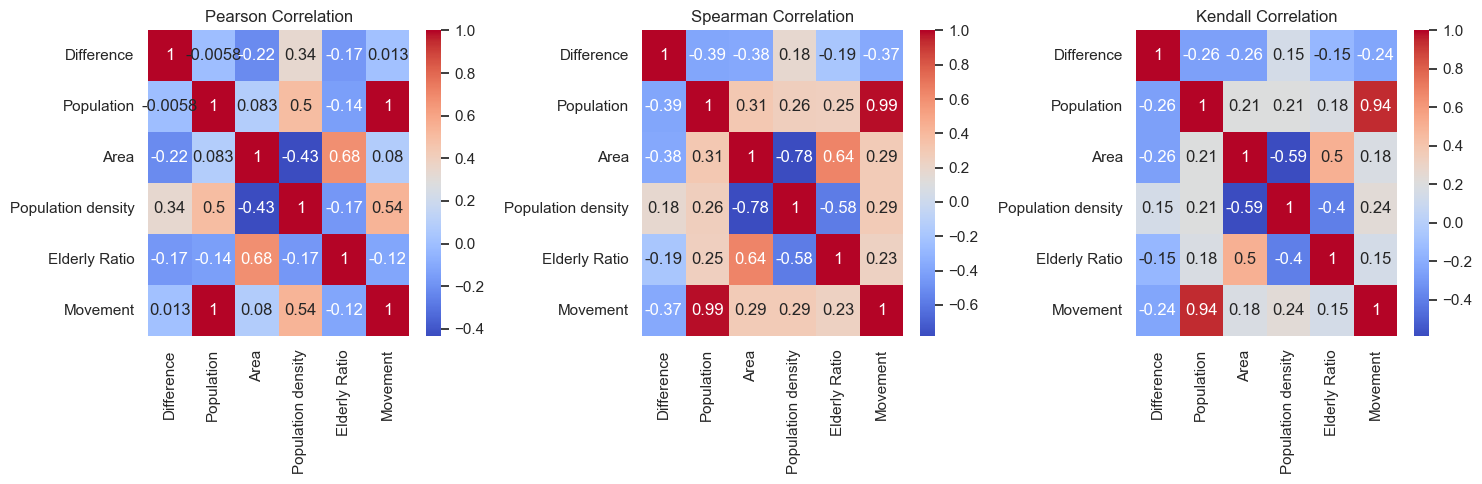

In [46]:
g_corr_heatmap(df)

In [47]:
y = df['Difference']
col_list = g_corr(df, y)

Population와 Difference의 상관 분석

    Pearson correlation coefficient: -0.005846921630323146
    p-value: 0.9822316177750243
    귀무가설 채택, 상관계수는 유의하지 않음

    Spearman correlation coefficient: -0.38970588235294124
    p-value: 0.12203439858782986
    귀무가설 채택, 상관계수는 유의하지 않음

    Kendall correlation coefficient: -0.2647058823529411
    p-value: 0.15133363966308636
    귀무가설 채택, 상관계수는 유의하지 않음

Area와 Difference의 상관 분석

    Pearson correlation coefficient: -0.2161866626048347
    p-value: 0.40462571750276843
    귀무가설 채택, 상관계수는 유의하지 않음

    Spearman correlation coefficient: -0.37500000000000006
    p-value: 0.13803484396804858
    귀무가설 채택, 상관계수는 유의하지 않음

    Kendall correlation coefficient: -0.2647058823529411
    p-value: 0.15133363966308636
    귀무가설 채택, 상관계수는 유의하지 않음

Population density와 Difference의 상관 분석

    Pearson correlation coefficient: 0.3362724023943412
    p-value: 0.18693330872622277
    귀무가설 채택, 상관계수는 유의하지 않음

    Spearman correlation coefficient: 0.17647058823529413
    p-value: 0.49

## 선형회귀분석

### OLS

In [48]:
y = df['Difference']
g_OLS(df, y, col_list)

### LOESS

In [49]:
y = df['Difference']
g_loess(df, y, col_list)

## down2

In [50]:
df = dic_df['down2']
df.head()

,City,Difference,Population,Area,Population density,Elderly Ratio,Movement
0,강원,3887.834294,1539277,16830,91.460309,22.5,2613930
1,경기,-1364.034204,13527299,10197,1326.595960,14.5,18144056
2,경남,5246.515802,3311631,10542,314.136881,19.2,5116038
3,경북,-1365.049669,2622174,19035,137.755398,23.5,4126661
4,광주,15878.510149,1440908,501,2876.063872,15.4,2350270


### 정규성 검정

Difference 검정 통계량 : 0.9593906402587891 , Difference p-value : 0.620055615901947
Difference은 정규성을 만족


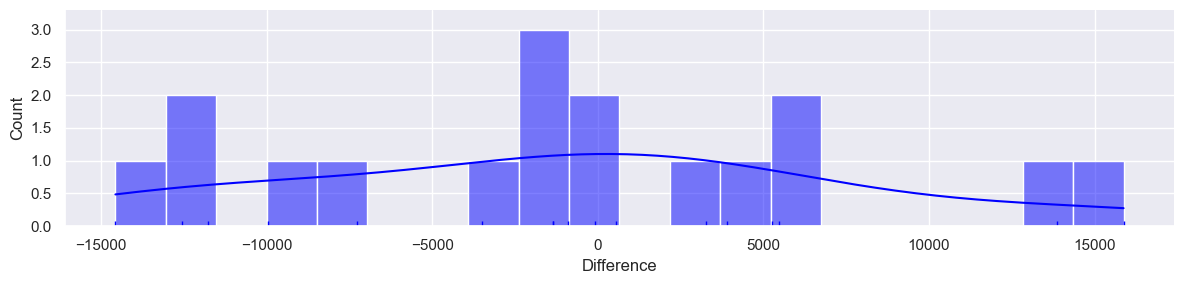

In [51]:
g_shapiro('Difference', df['Difference'])
sns.displot(df['Difference'], color = 'blue', kde = True, rug = True, aspect = 4, height = 3, bins = 20)
plt.show()

## 상관분석

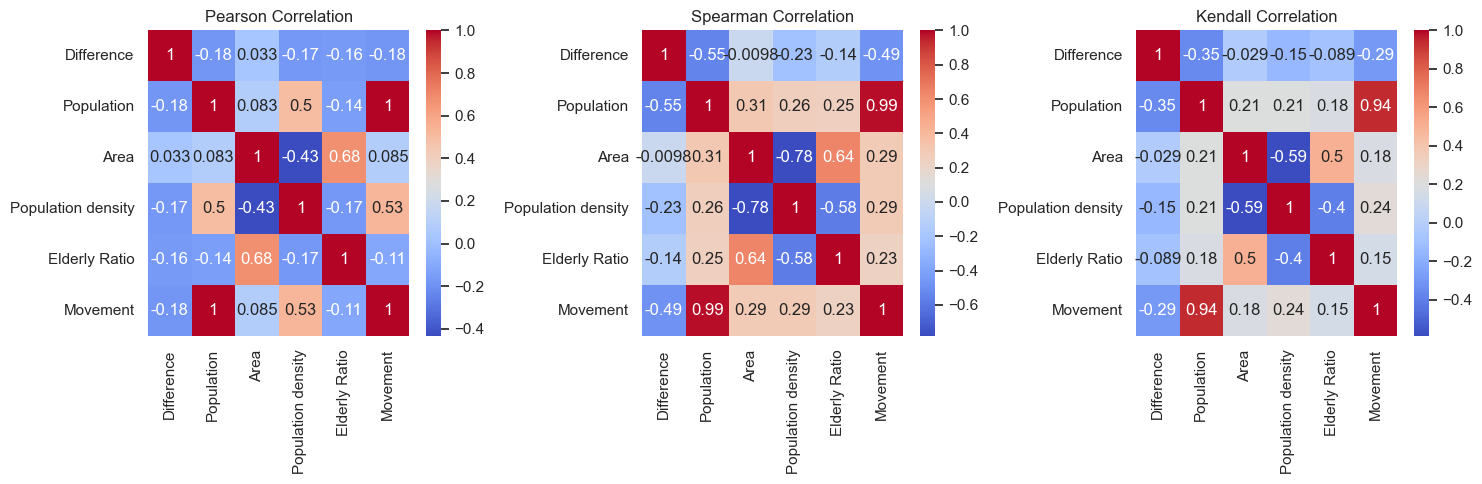

In [52]:
g_corr_heatmap(df)

In [53]:
y = df['Difference']
col_list = g_corr(df, y)

Population와 Difference의 상관 분석

    Pearson correlation coefficient: -0.17903726142340565
    p-value: 0.4917364179807923
    귀무가설 채택, 상관계수는 유의하지 않음

    Spearman correlation coefficient: -0.5514705882352942
    p-value: 0.021746579686423562
    귀무가설 기각, 상관계수는 유의함

    Kendall correlation coefficient: -0.3529411764705882
    p-value: 0.05175324945907756
    귀무가설 채택, 상관계수는 유의하지 않음

Area와 Difference의 상관 분석

    Pearson correlation coefficient: 0.0326280723796802
    p-value: 0.9010665725654983
    귀무가설 채택, 상관계수는 유의하지 않음

    Spearman correlation coefficient: -0.009803921568627453
    p-value: 0.9702105713958575
    귀무가설 채택, 상관계수는 유의하지 않음

    Kendall correlation coefficient: -0.02941176470588235
    p-value: 0.9031966906069087
    귀무가설 채택, 상관계수는 유의하지 않음

Population density와 Difference의 상관 분석

    Pearson correlation coefficient: -0.17079012896411222
    p-value: 0.5122164069444597
    귀무가설 채택, 상관계수는 유의하지 않음

    Spearman correlation coefficient: -0.22794117647058826
    p-value: 0.3789105

## 선형회귀분석

### OLS

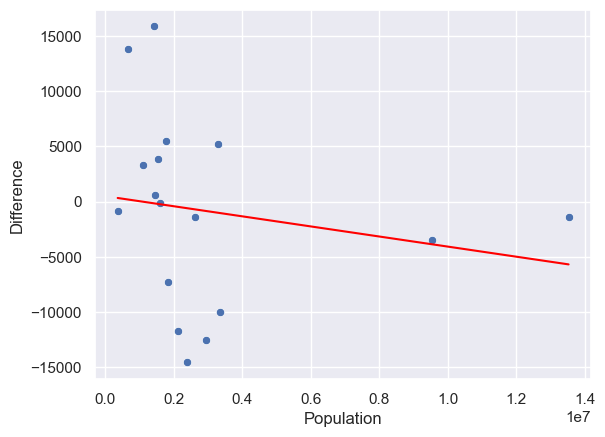

y = -0.0005x + 494.6582

                            OLS Regression Results                            
Dep. Variable:             Difference   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                 -0.032
Method:                 Least Squares   F-statistic:                    0.4967
Date:                Thu, 29 Jun 2023   Prob (F-statistic):              0.492
Time:                        01:49:01   Log-Likelihood:                -177.41
No. Observations:                  17   AIC:                             358.8
Df Residuals:                      15   BIC:                             360.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        494.6582   290

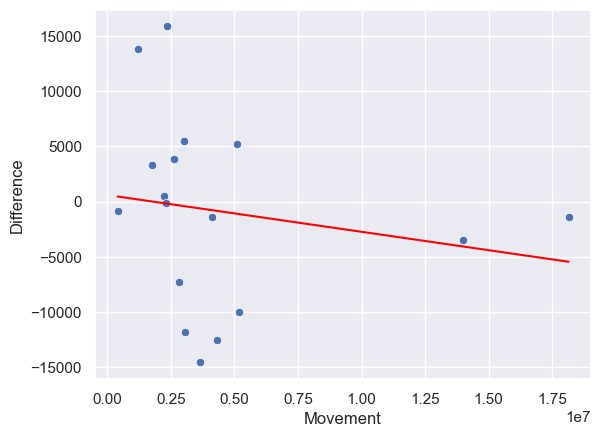

y = -0.0003x + 601.3460

                            OLS Regression Results                            
Dep. Variable:             Difference   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                 -0.033
Method:                 Least Squares   F-statistic:                    0.4890
Date:                Thu, 29 Jun 2023   Prob (F-statistic):              0.495
Time:                        01:49:01   Log-Likelihood:                -177.41
No. Observations:                  17   AIC:                             358.8
Df Residuals:                      15   BIC:                             360.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        601.3460   301

In [54]:
y = df['Difference']
g_OLS(df, y, col_list)

### LOESS

Population


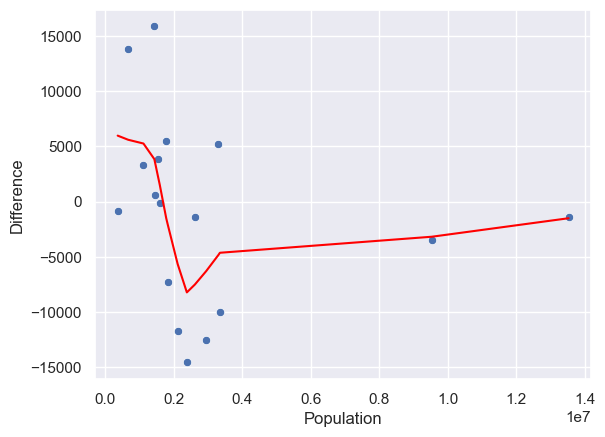

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.088
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     1.455
Date:                Thu, 29 Jun 2023   Prob (F-statistic):              0.246
Time:                        01:49:02   Log-Likelihood:                -167.03
No. Observations:                  17   AIC:                             338.1
Df Residuals:                      15   BIC:                             339.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        276.7047   1575.670      0.176      0.8

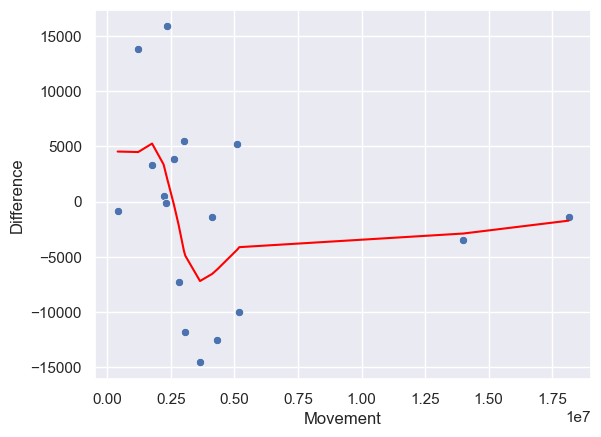

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.092
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     1.527
Date:                Thu, 29 Jun 2023   Prob (F-statistic):              0.236
Time:                        01:49:02   Log-Likelihood:                -164.82
No. Observations:                  17   AIC:                             333.6
Df Residuals:                      15   BIC:                             335.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -50.1167   1438.897     -0.035      0.9

In [55]:
y = df['Difference']
g_loess(df, y, col_list)

# SIR_alpha

In [56]:
key = 'SIR'
var_list = ['up1', 'up2', 'down1', 'down2']
city_list = ['강원', '경기', '경남', '경북', '광주', '대구', 
          '대전', '부산', '서울', '세종', '울산', '인천',
          '전남', '전북', '제주', '충남', '충북']

path = f'Data/Predicted/Stricgency/{key}_alpha/valid_score.pkl'
with open(path, 'rb') as f:
    dic_valid_score = pickle.load(f)
    
df_cities = pd.read_csv('Data/Statistics/Correlation.csv', encoding = 'cp949')

In [57]:
dic_valid = {}
for var in var_list:
    valid_list = []
    for city in city_list:
        valid_list.append([city, dic_valid_score[var][city]['best_model'][3]])
        
    dic_valid[var] = valid_list
    
dic_valid.keys()

dic_df = {}
for var in var_list:
    dic_df[var] = pd.concat([pd.DataFrame(dic_valid[var], columns = ['City', 'Difference']), df_cities.iloc[:, 1:]], axis = 1)
    dic_df[var]['Movement'] = (df_movement.sort_index(axis = 1)
                               .iloc[var_date_index[key][var],:-1]
                               .reset_index(drop = True)
                               .astype('int64'))

## up1

In [58]:
df = dic_df['up1']
df.head()

,City,Difference,Population,Area,Population density,Elderly Ratio,Movement
0,강원,0.153639,1539277,16830,91.460309,22.5,2269308
1,경기,0.053421,13527299,10197,1326.595960,14.5,16953318
2,경남,0.075771,3311631,10542,314.136881,19.2,4866917
3,경북,-0.650270,2622174,19035,137.755398,23.5,3756940
4,광주,-0.007692,1440908,501,2876.063872,15.4,2169744


### 정규성 검정

Difference 검정 통계량 : 0.946491003036499 , Difference p-value : 0.4034373164176941
Difference은 정규성을 만족


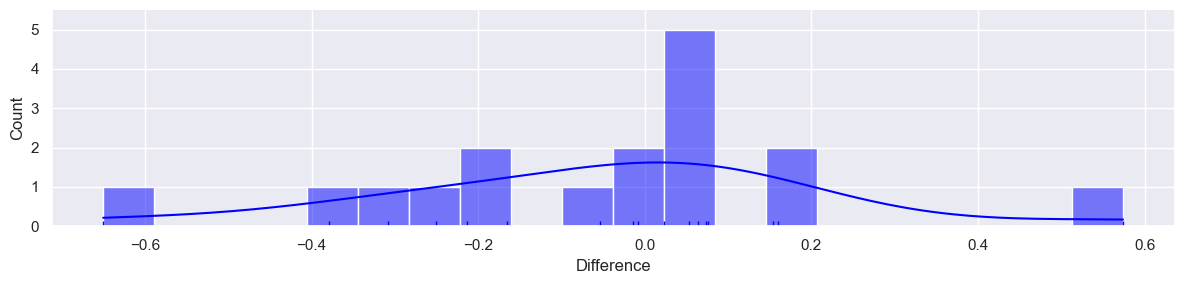

In [59]:
g_shapiro('Difference', df['Difference'])
sns.displot(df['Difference'], color = 'blue', kde = True, rug = True, aspect = 4, height = 3, bins = 20)
plt.show()

## 상관분석

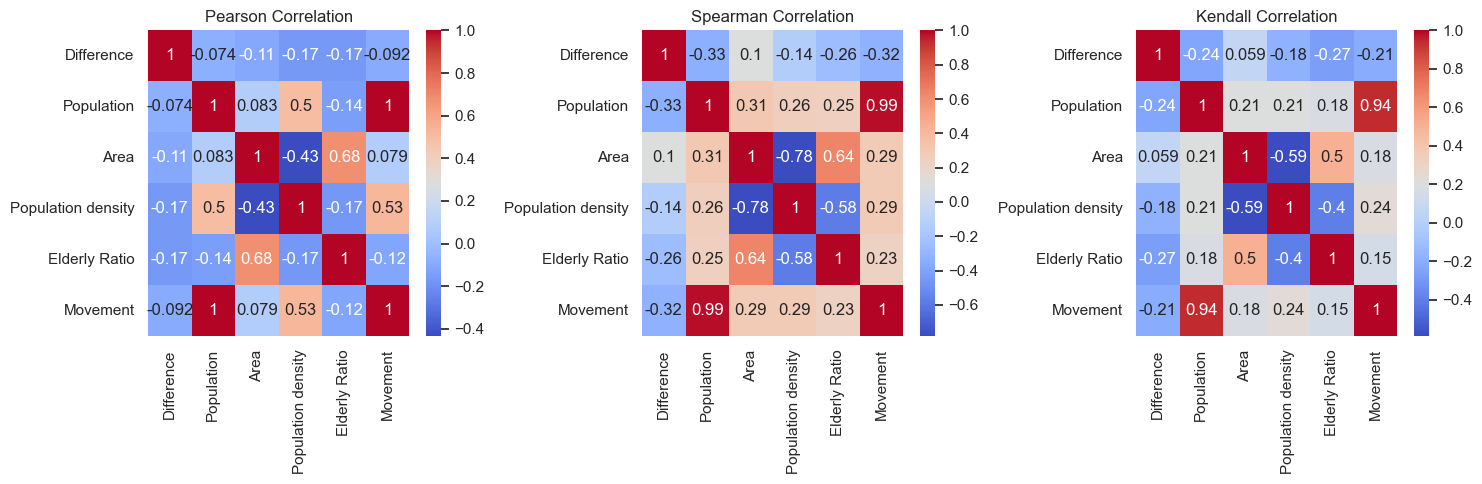

In [60]:
g_corr_heatmap(df)

In [61]:
y = df['Difference']
col_list = g_corr(df, y)

Population와 Difference의 상관 분석

    Pearson correlation coefficient: -0.07434029355157125
    p-value: 0.776749150739463
    귀무가설 채택, 상관계수는 유의하지 않음

    Spearman correlation coefficient: -0.33333333333333337
    p-value: 0.19105762734590404
    귀무가설 채택, 상관계수는 유의하지 않음

    Kendall correlation coefficient: -0.2352941176470588
    p-value: 0.20489900152579948
    귀무가설 채택, 상관계수는 유의하지 않음

Area와 Difference의 상관 분석

    Pearson correlation coefficient: -0.1086973254712213
    p-value: 0.6779459485484534
    귀무가설 채택, 상관계수는 유의하지 않음

    Spearman correlation coefficient: 0.10294117647058824
    p-value: 0.6942047830993174
    귀무가설 채택, 상관계수는 유의하지 않음

    Kendall correlation coefficient: 0.0588235294117647
    p-value: 0.7764940676883935
    귀무가설 채택, 상관계수는 유의하지 않음

Population density와 Difference의 상관 분석

    Pearson correlation coefficient: -0.16542660622614017
    p-value: 0.5257456177531864
    귀무가설 채택, 상관계수는 유의하지 않음

    Spearman correlation coefficient: -0.13970588235294118
    p-value: 0.5928010

## 선형회귀분석

### OLS

In [62]:
y = df['Difference']
g_OLS(df, y, col_list)

### LOESS

In [63]:
y = df['Difference']
g_loess(df, y, col_list)

## up2

In [64]:
df = dic_df['up2']
df.head()

,City,Difference,Population,Area,Population density,Elderly Ratio,Movement
0,강원,0.117638,1539277,16830,91.460309,22.5,2407919
1,경기,-0.012633,13527299,10197,1326.595960,14.5,17765571
2,경남,0.303352,3311631,10542,314.136881,19.2,4925279
3,경북,0.360135,2622174,19035,137.755398,23.5,4017947
4,광주,0.068236,1440908,501,2876.063872,15.4,2277573


### 정규성 검정

Difference 검정 통계량 : 0.9368600845336914 , Difference p-value : 0.2828156650066376
Difference은 정규성을 만족


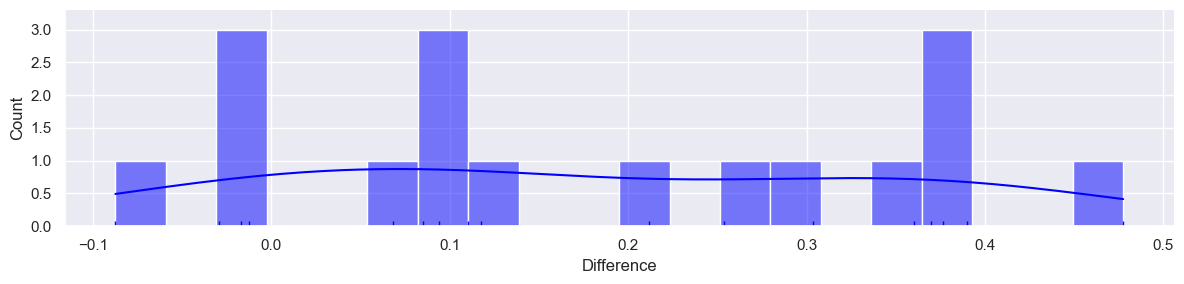

In [65]:
g_shapiro('Difference', df['Difference'])
sns.displot(df['Difference'], color = 'blue', kde = True, rug = True, aspect = 4, height = 3, bins = 20)
plt.show()

## 상관분석

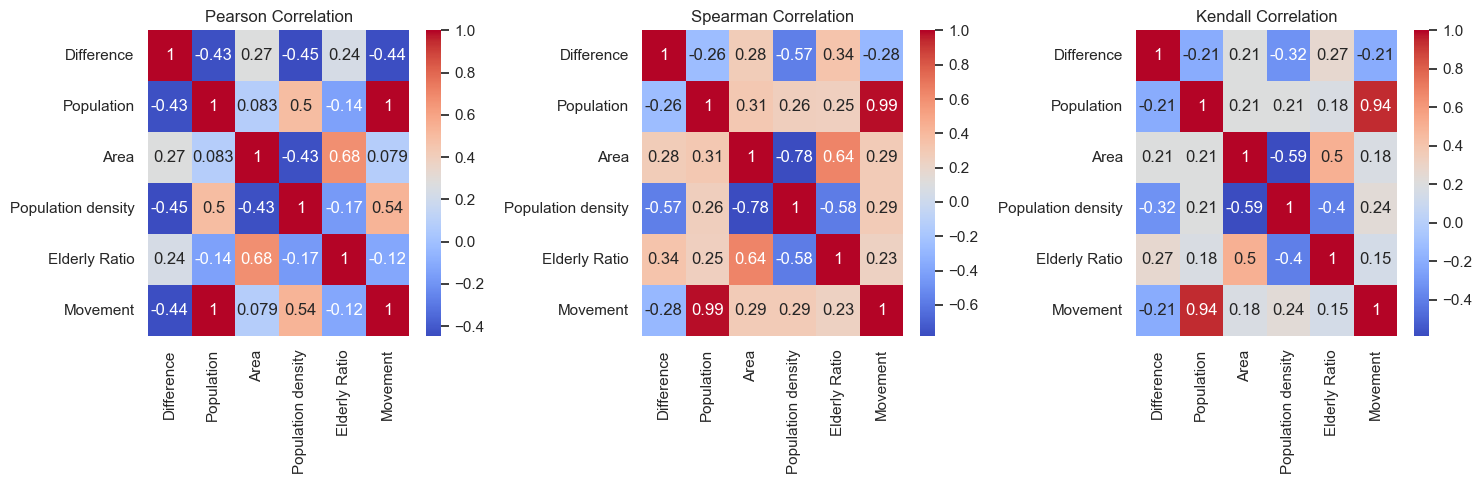

In [66]:
g_corr_heatmap(df)

In [67]:
y = df['Difference']
col_list = g_corr(df, y)

Population와 Difference의 상관 분석

    Pearson correlation coefficient: -0.43097884342992154
    p-value: 0.08414499728151723
    귀무가설 채택, 상관계수는 유의하지 않음

    Spearman correlation coefficient: -0.2573529411764706
    p-value: 0.3186676476453986
    귀무가설 채택, 상관계수는 유의하지 않음

    Kendall correlation coefficient: -0.20588235294117643
    p-value: 0.27056053596407176
    귀무가설 채택, 상관계수는 유의하지 않음

Area와 Difference의 상관 분석

    Pearson correlation coefficient: 0.2742158328619859
    p-value: 0.28683558284191507
    귀무가설 채택, 상관계수는 유의하지 않음

    Spearman correlation coefficient: 0.28186274509803927
    p-value: 0.27305989737995473
    귀무가설 채택, 상관계수는 유의하지 않음

    Kendall correlation coefficient: 0.20588235294117643
    p-value: 0.27056053596407176
    귀무가설 채택, 상관계수는 유의하지 않음

Population density와 Difference의 상관 분석

    Pearson correlation coefficient: -0.4467567469592746
    p-value: 0.07220568241334231
    귀무가설 채택, 상관계수는 유의하지 않음

    Spearman correlation coefficient: -0.5661764705882354
    p-value: 0.0178

### OLS

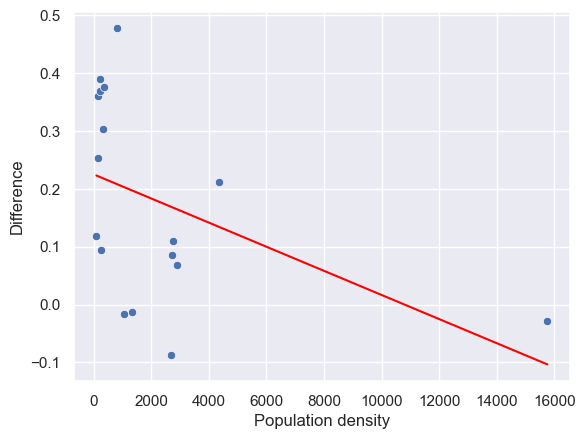

y = -0.0000x + 0.2249

                            OLS Regression Results                            
Dep. Variable:             Difference   R-squared:                       0.200
Model:                            OLS   Adj. R-squared:                  0.146
Method:                 Least Squares   F-statistic:                     3.740
Date:                Thu, 29 Jun 2023   Prob (F-statistic):             0.0722
Time:                        01:49:05   Log-Likelihood:                 7.9172
No. Observations:                  17   AIC:                            -11.83
Df Residuals:                      15   BIC:                            -10.17
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const        

In [68]:
y = df['Difference']
g_OLS(df, y, col_list)

### LOESS

Population density


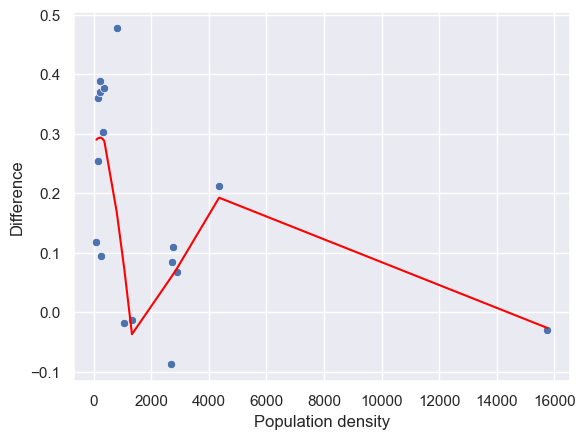

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.351
Model:                            OLS   Adj. R-squared:                  0.307
Method:                 Least Squares   F-statistic:                     8.096
Date:                Thu, 29 Jun 2023   Prob (F-statistic):             0.0123
Time:                        01:49:06   Log-Likelihood:                 15.263
No. Observations:                  17   AIC:                            -26.53
Df Residuals:                      15   BIC:                            -24.86
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2167      0.029      7.353      0.0

In [69]:
y = df['Difference']
g_loess(df, y, col_list)

## down1

In [70]:
df = dic_df['down1']
df.head()

,City,Difference,Population,Area,Population density,Elderly Ratio,Movement
0,강원,-0.110945,1539277,16830,91.460309,22.5,2431510
1,경기,0.004362,13527299,10197,1326.595960,14.5,17823822
2,경남,-0.144974,3311631,10542,314.136881,19.2,5071967
3,경북,-0.082759,2622174,19035,137.755398,23.5,4010493
4,광주,0.280183,1440908,501,2876.063872,15.4,2266118


### 정규성 검정

Difference 검정 통계량 : 0.9607537388801575 , Difference p-value : 0.6456899642944336
Difference은 정규성을 만족


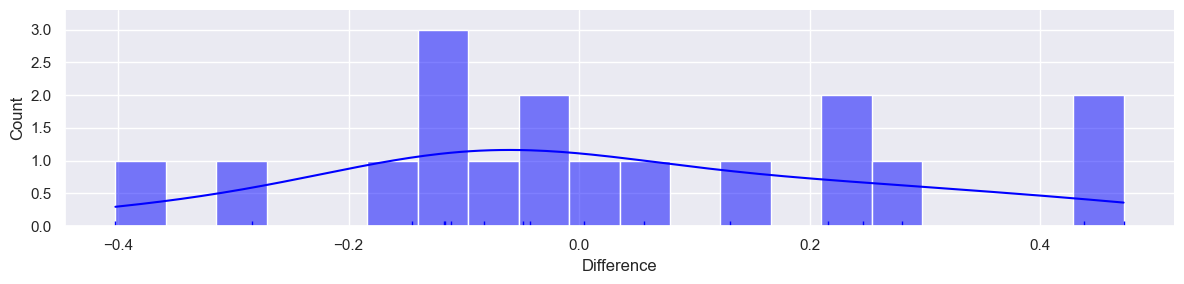

In [71]:
g_shapiro('Difference', df['Difference'])
sns.displot(df['Difference'], color = 'blue', kde = True, rug = True, aspect = 4, height = 3, bins = 20)
plt.show()

## 상관분석

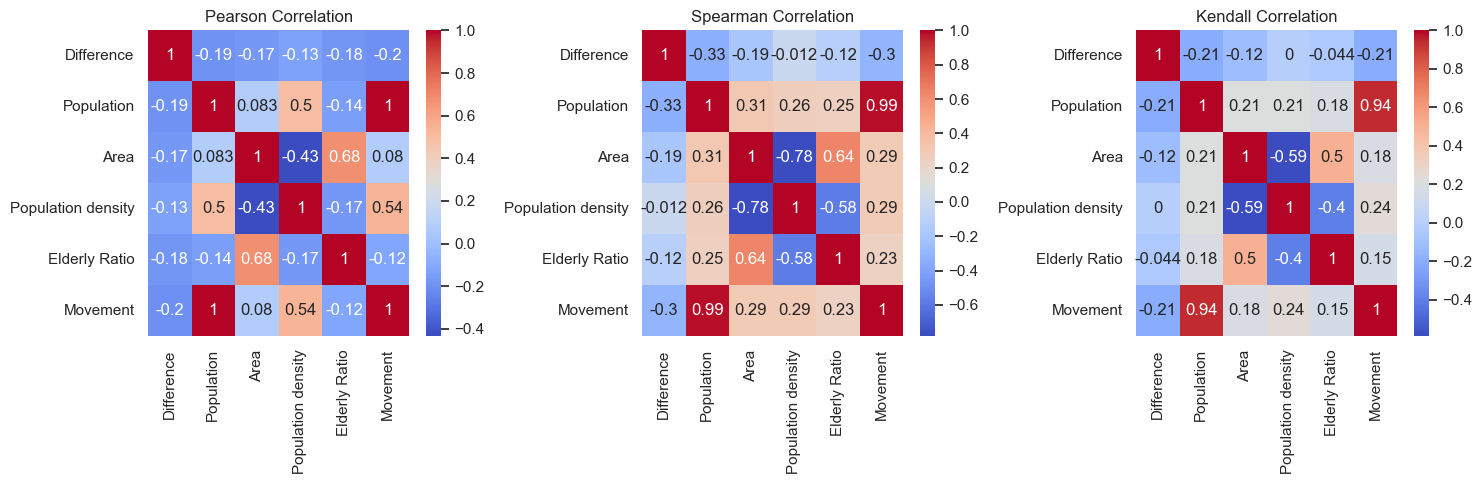

In [72]:
g_corr_heatmap(df)

In [73]:
y = df['Difference']
col_list = g_corr(df, y)

Population와 Difference의 상관 분석

    Pearson correlation coefficient: -0.18862300239048826
    p-value: 0.46843837924326676
    귀무가설 채택, 상관계수는 유의하지 않음

    Spearman correlation coefficient: -0.33333333333333337
    p-value: 0.19105762734590404
    귀무가설 채택, 상관계수는 유의하지 않음

    Kendall correlation coefficient: -0.20588235294117643
    p-value: 0.27056053596407176
    귀무가설 채택, 상관계수는 유의하지 않음

Area와 Difference의 상관 분석

    Pearson correlation coefficient: -0.17480276474983425
    p-value: 0.5022024053662385
    귀무가설 채택, 상관계수는 유의하지 않음

    Spearman correlation coefficient: -0.18627450980392157
    p-value: 0.4740951399440866
    귀무가설 채택, 상관계수는 유의하지 않음

    Kendall correlation coefficient: -0.1176470588235294
    p-value: 0.5423278567488096
    귀무가설 채택, 상관계수는 유의하지 않음

Population density와 Difference의 상관 분석

    Pearson correlation coefficient: -0.13391995587340635
    p-value: 0.6083528549929713
    귀무가설 채택, 상관계수는 유의하지 않음

    Spearman correlation coefficient: -0.012254901960784315
    p-value: 0.

## 선형회귀분석

### OLS

In [74]:
y = df['Difference']
g_OLS(df, y, col_list)

### LOESS

In [75]:
y = df['Difference']
g_loess(df, y, col_list)

## down2

In [76]:
df = dic_df['down2']
df.head()

,City,Difference,Population,Area,Population density,Elderly Ratio,Movement
0,강원,0.103672,1539277,16830,91.460309,22.5,2613930
1,경기,-0.021146,13527299,10197,1326.595960,14.5,18144056
2,경남,0.077320,3311631,10542,314.136881,19.2,5116038
3,경북,-0.079149,2622174,19035,137.755398,23.5,4126661
4,광주,0.167784,1440908,501,2876.063872,15.4,2350270


### 정규성 검정

Difference 검정 통계량 : 0.984992265701294 , Difference p-value : 0.9890084862709045
Difference은 정규성을 만족


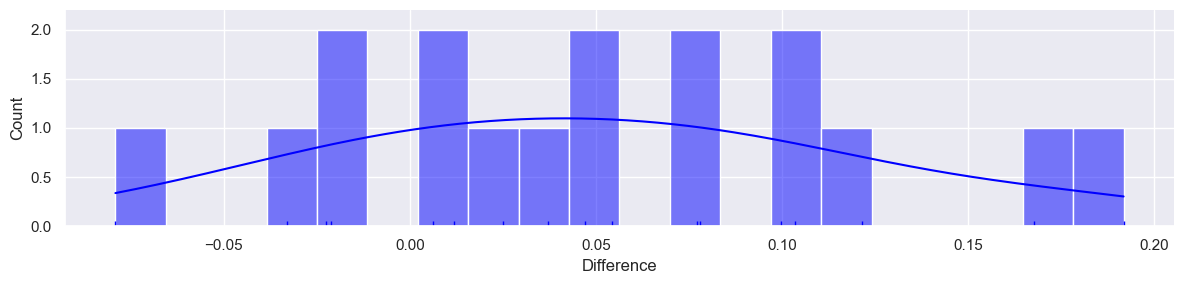

In [77]:
g_shapiro('Difference', df['Difference'])
sns.displot(df['Difference'], color = 'blue', kde = True, rug = True, aspect = 4, height = 3, bins = 20)
plt.show()

## 상관분석

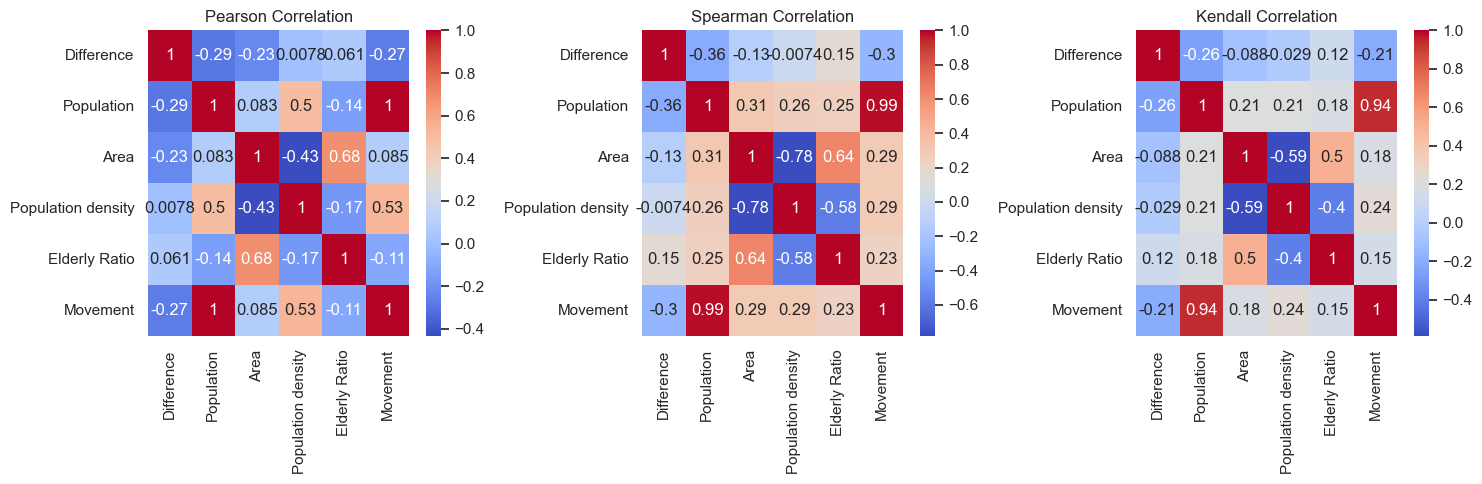

In [78]:
g_corr_heatmap(df)

In [79]:
y = df['Difference']
col_list = g_corr(df, y)

Population와 Difference의 상관 분석

    Pearson correlation coefficient: -0.29088319097047255
    p-value: 0.25734075989204797
    귀무가설 채택, 상관계수는 유의하지 않음

    Spearman correlation coefficient: -0.35784313725490197
    p-value: 0.1584639899823692
    귀무가설 채택, 상관계수는 유의하지 않음

    Kendall correlation coefficient: -0.2647058823529411
    p-value: 0.15133363966308636
    귀무가설 채택, 상관계수는 유의하지 않음

Area와 Difference의 상관 분석

    Pearson correlation coefficient: -0.2319051881351406
    p-value: 0.3704468068084446
    귀무가설 채택, 상관계수는 유의하지 않음

    Spearman correlation coefficient: -0.12745098039215688
    p-value: 0.6259301508467393
    귀무가설 채택, 상관계수는 유의하지 않음

    Kendall correlation coefficient: -0.08823529411764705
    p-value: 0.6553075802476113
    귀무가설 채택, 상관계수는 유의하지 않음

Population density와 Difference의 상관 분석

    Pearson correlation coefficient: 0.007804132424080484
    p-value: 0.9762851650839263
    귀무가설 채택, 상관계수는 유의하지 않음

    Spearman correlation coefficient: -0.007352941176470588
    p-value: 0.97

## 선형회귀분석

### OLS

In [80]:
y = df['Difference']
g_OLS(df, y, col_list)

### LOESS

In [81]:
y = df['Difference']
g_loess(df, y, col_list)

# Explain

"Kernel Regression"과 "Local Polynomial Regression"은 비모수 회귀분석 방법으로 비선형 관계를 모델링하기 위해 사용됩니다. 하지만 두 방법은 약간의 차이가 있습니다. 아래에서 각 방법의 특징을 자세히 설명하겠습니다:

1. Kernel Regression:

- 커널 함수를 사용하여 가중 평균을 계산하고 추세선을 생성합니다.
- 가중치는 커널 함수에 의해 결정되며, 데이터 포인트와의 거리에 따라 가중치가 부여됩니다.
- 주변 데이터의 영향력을 고려하여 예측값을 계산합니다.
- 주변 데이터의 밀도와 데이터 포인트 간의 거리에 따라 모델의 부드러움을 조절할 수 있습니다.
대표적인 예로 LOESS (Locally Weighted Scatterplot Smoothing)가 있습니다.

주어진 데이터에 대한 비모수 회귀분석을 수행하기 위해 LOESS (Locally Weighted Scatterplot Smoothing) 방법을 선택한 이유는 다음과 같습니다:

1. 데이터의 특성:
   - 주어진 데이터는 비모수적인 특성을 가지고 있습니다. 비선형적인 패턴을 가지고 있을 수 있으며, 정규성을 따르지 않을 수 있습니다.
   - LOESS는 비선형적인 관계를 모델링하는 데 적합한 방법 중 하나입니다. 이는 데이터의 비선형성을 잘 캡처하여 모델을 구성할 수 있음을 의미합니다.

2. 데이터의 밀도:
   - 주어진 데이터의 밀도가 균일하지 않을 수 있습니다. 이는 주변 데이터의 밀도가 다를 수 있다는 의미입니다.
   - LOESS는 커널 함수를 사용하여 데이터 포인트 간의 거리에 따라 가중치를 부여하는 방식으로 추세선을 생성합니다. 이를 통해 주변 데이터의 밀도를 고려하여 모델을 구성할 수 있습니다.

3. 모델의 유연성:
   - LOESS는 다항식 회귀보다 더 유연한 모델링을 제공합니다. 추세선의 부드러운 곡선 형태로 데이터에 적합하게 모델링될 수 있습니다.
   - 다항식 회귀에 비해 고차항을 선택하는 번거로움 없이 데이터의 패턴에 적합한 추세선을 얻을 수 있습니다.

따라서, 주어진 비모수 데이터에 대한 비모수 회귀분석에서 LOESS 방법을 선택한 이유는 데이터의 비선형성, 밀도의 비균일성, 그리고 모델의 유연성을 고려하여 데이터에 적합한 추세선을 생성하기 위함입니다.